In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

os.chdir('../../data/SirajMPRA')
sys.path.append('/home/hxcai/cell_type_specific_CRE')
from MPRA_exp.utils import *

In [3]:
df = pd.read_csv('SirajMPRA_len200.csv', sep='\t')

In [4]:
df

seq  A549     HepG2  \
0       AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...   NaN  0.667516   
1       AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...   NaN  0.415984   
2       CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...   NaN  1.269937   
3       CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...   NaN  1.151995   
4       AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...   NaN -0.211076   
...                                                   ...   ...       ...   
585600  ATCATTTACTGGTGACTGCCCTGCTAGGGTGTCAGCTGTCAGATCC...   NaN  0.615976   
585601  TGGTTACTGCAGGGGCAGGGTTTTGGCAGGAAATAAACATGCACGG...   NaN  1.409758   
585602  TGGTTACTGCAGGGGCAGGGTTTTGGCAGGAAATAAACATGCACGG...   NaN  0.894634   
585603  TGGTGAGTTGCTTCTGTGCACACACTTTTGTTTATGAGTGTGCATG...   NaN  0.312172   
585604  TGGTGAGTTGCTTCTGTGCACACACTTTTGTTTATGAGTGTGCATG...   NaN  0.370818   

            K562     SKNSH    HCT116  is_ref   chr        pos ref alt  
0      -0.704147  0.538641  0.159069    True  chr1      14677   G   A  
1       0.554099  0.441904 -0.288019   False  chr1      14677   G   A  
2      -0.391222  0.752052  1.100437    True  chr1      63697   T   C  
3      -0.659023  0.204721  1.050619   False  chr1      63697   T   C  
4      -0.007174  0.499376  0.257572    True  chr1      64764   C   T  
...          ...       ...       ...     ...   ...        ...  ..  ..  
585600  1.927090  0.798263  1.035440   False  chrX  155233098   T   C  
585601  0.556338  2.843295  1.495515    True  chrX  155233794   A   G  
585602 -0.072647  1.973661  0.794848   False  chrX  155233794   A   G  
585603  0.165634 -0.041383  0.444472    True  chrX  155234730   T   C  
585604  0.009694 -0.035569  0.407723   False  chrX  155234730   T   C  

[585605 rows x 11 columns]

In [5]:
r = pearsonr(df['HepG2'], df['K562'])[0]
print(f'pearsonr = {r:.3f}')

g = sns.jointplot(x=df['HepG2'], y=df['K562'], kind='hist', bins=100, alpha=0.8)
g.fig.set_size_inches(8, 8)

# 调整主图的网格间距
g.ax_joint.xaxis.set_major_locator(plt.MultipleLocator(1))
g.ax_joint.yaxis.set_major_locator(plt.MultipleLocator(1))

plt.text(0.05, 0.95, f'pearsonr = {r:.3f}', transform=g.ax_joint.transAxes)

plt.savefig('SirajMPRA_HepG2_K562.png', dpi=500)

ValueError: array must not contain infs or NaNs

In [3]:
# import pyBigWig
# bw = pyBigWig.open("../ATAC/HepG2_ENCFF285FQS.bigWig")
# chr, start, end = 'chr1', 200, 300
# values = bw.values(chr, start, end)
# print(values)

[urlOpen] Couldn't open ../ATAC/HepG2_ENCFF285FQS.bigWig for reading
[urlOpen] Couldn't open ../ATAC/HepG2_ENCFF285FQS.bigWig for reading
[pyBwOpen] bw is NULL!


RuntimeError: Received an error during file opening!

In [4]:
# import pyBigWig
# bw = pyBigWig.open("../ATAC/HepG2_ENCFF664EJT.bigWig")

# df['HepG2_bw_value'] = np.nan

# for i, data in tqdm(df.iterrows()):
#     chr, start, end = data['chr'], data['start'], data['end']
#     try:
#         values = bw.values(chr, start, end)
#         df.at[i, 'HepG2_bw_value'] = np.mean(values)
#     except RuntimeError as e:
#         pass
#         # print(f"Error for {chr}:{start}-{end}: {e}")
# bw.close()

278886it [00:46, 5976.80it/s]


In [2]:
import pyBigWig

def add_bw_value(df, bw_file):
    bw = pyBigWig.open(bw_file)

    df['bw_value'] = np.nan

    for i, data in tqdm(df.iterrows(), total=df.shape[0]):
        chr, start, end = data['chr'], data['start'], data['end']
        try:
            values = bw.values(chr, start, end)
            df.at[i, 'bw_value'] = np.mean(values)
        except RuntimeError as e:
            pass
            # print(f"Error for {chr}:{start}-{end}: {e}")
    bw.close()




def get_bw_value(df, bw_file):
    bw = pyBigWig.open(bw_file)

    bw_value = []

    for i, data in tqdm(df.iterrows(), total=df.shape[0]):
        chr, start, end = data['chr'], data['start'], data['end']
        try:
            values = bw.values(chr, start, end)
            bw_value.append(np.mean(values))
        except RuntimeError as e:
            bw_value.append(np.nan)
            pass
            # print(f"Error for {chr}:{start}-{end}: {e}")
    bw.close()

    return np.array(bw_value)

In [3]:
import subprocess

def add_overlap(df, atac_peaks_bed_file, col_name):
    # 保存df为一个临时BED文件
    df_bed_file = 'df_bed_file.bed'
    df.to_csv(df_bed_file, sep='\t', columns=['chr', 'start', 'end'], header=False, index=False)
    intersect_file = 'df_intersect.bed'

    # 使用bedtools intersect命令检查交叉情况
    intersect_command = f"bedtools intersect -a {df_bed_file} -b {atac_peaks_bed_file} -wa -c > {intersect_file}"
    subprocess.run(intersect_command, shell=True)

    result_df = pd.read_csv(intersect_file, names=['chr', 'start', 'end', 'overlap'], sep='\t')
    df[col_name] = result_df['overlap']
    
    os.remove(df_bed_file)
    os.remove(intersect_file)


def get_overlap(df, atac_peaks_bed_file):
    # 保存df为一个临时BED文件
    df_bed_file = 'df_bed_file.bed'
    df.to_csv(df_bed_file, sep='\t', columns=['chr', 'start', 'end'], header=False, index=False)
    intersect_file = 'df_intersect.bed'

    # 使用bedtools intersect命令检查交叉情况
    intersect_command = f"bedtools intersect -a {df_bed_file} -b {atac_peaks_bed_file} -wa -c > {intersect_file}"
    subprocess.run(intersect_command, shell=True)

    result_df = pd.read_csv(intersect_file, names=['chr', 'start', 'end', 'overlap'], sep='\t')
    os.remove(df_bed_file)
    os.remove(intersect_file)

    return result_df['overlap']

In [4]:
"../ATAC/HepG2_ENCFF664EJT.bigWig"
"../ATAC/HepG2_ENCFF664EJT.bigWig"

'../ATAC/HepG2_ENCFF664EJT.bigWig'

In [5]:
df = pd.read_csv('SirajMPRA_epi.csv', sep='\t')

In [8]:
df['HepG2_overlap'] = get_overlap(df, '../ATAC/HepG2_ENCFF438JMM_IDR.bed')
df['K562_overlap'] = get_overlap(df, '../ATAC/K562_ENCFF925CYR_IDR.bed')

In [9]:
df

chr      start        end     HepG2      K562     SKNSH  \
0       chr1      14577      14777  0.667516 -0.704147  0.538641   
1       chr1      63597      63797  1.269937 -0.391222  0.752052   
2       chr1      64664      64864 -0.211076 -0.007174  0.499376   
3       chr1     108130     108330 -0.332957 -0.149145 -1.048676   
4       chr1     108726     108926  0.607715  0.233677  0.511200   
...      ...        ...        ...       ...       ...       ...   
274922  chrX  155232003  155232203  0.579187  0.413490  0.651832   
274923  chrX  155232738  155232938 -0.351845  0.458449 -0.744355   
274924  chrX  155232998  155233198 -0.467091  0.338415 -0.797860   
274925  chrX  155233694  155233894  1.409758  0.556338  2.843295   
274926  chrX  155234630  155234830  0.312172  0.165634 -0.041383   

        HepG2_bw_value  K562_bw_value  HepG2_overlap  K562_overlap  
0             0.000000       0.000000              0             0  
1             0.000000       0.256219              0             0  
2             0.280116       0.533329              0             0  
3             0.000000       0.129465              0             0  
4             0.000000       0.130370              0             0  
...                ...            ...            ...           ...  
274922        0.036590       0.103210              0             0  
274923        0.324396       1.158998              0             0  
274924        0.605488       1.344624              0             0  
274925        0.645933       0.220926              0             0  
274926        0.423532       0.833065              0             0  

[274927 rows x 10 columns]

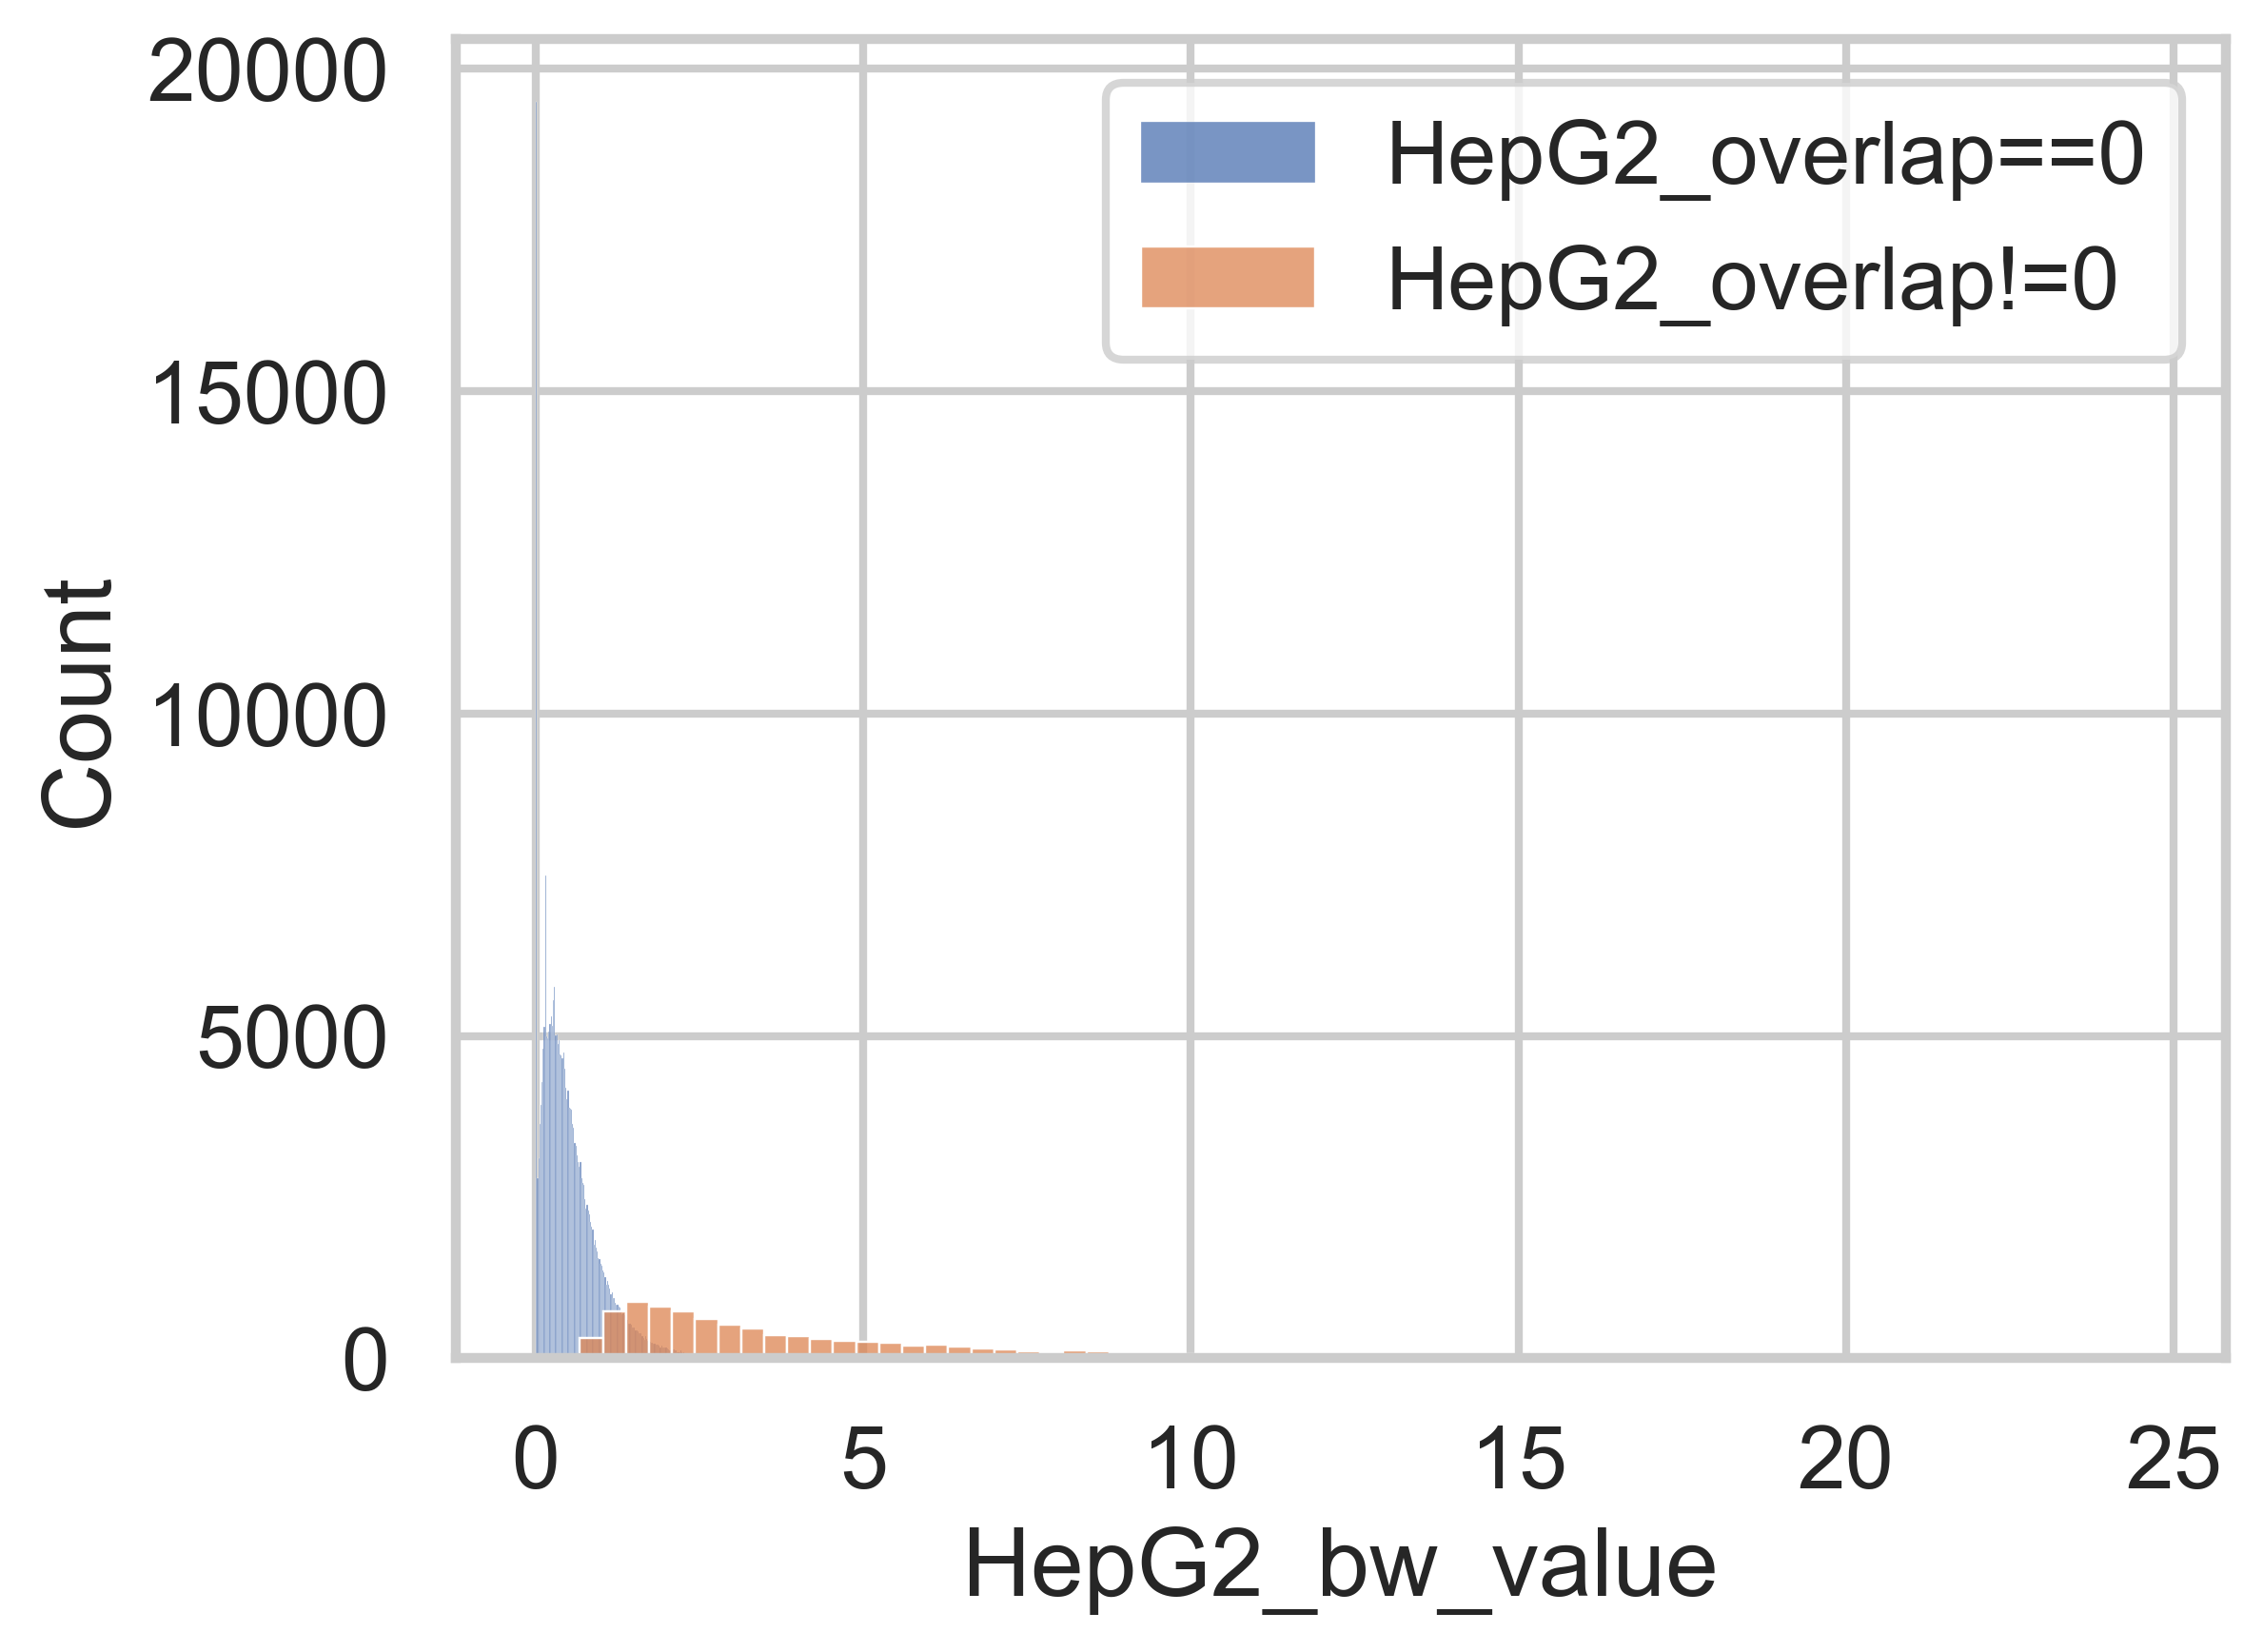

In [12]:
df0 = df[df['HepG2_overlap'] == 0]
g = sns.histplot(x=df0['HepG2_bw_value'], label='HepG2_overlap==0')
df0 = df[df['HepG2_overlap'] != 0]
g = sns.histplot(x=df0['HepG2_bw_value'], label='HepG2_overlap!=0')
plt.legend()

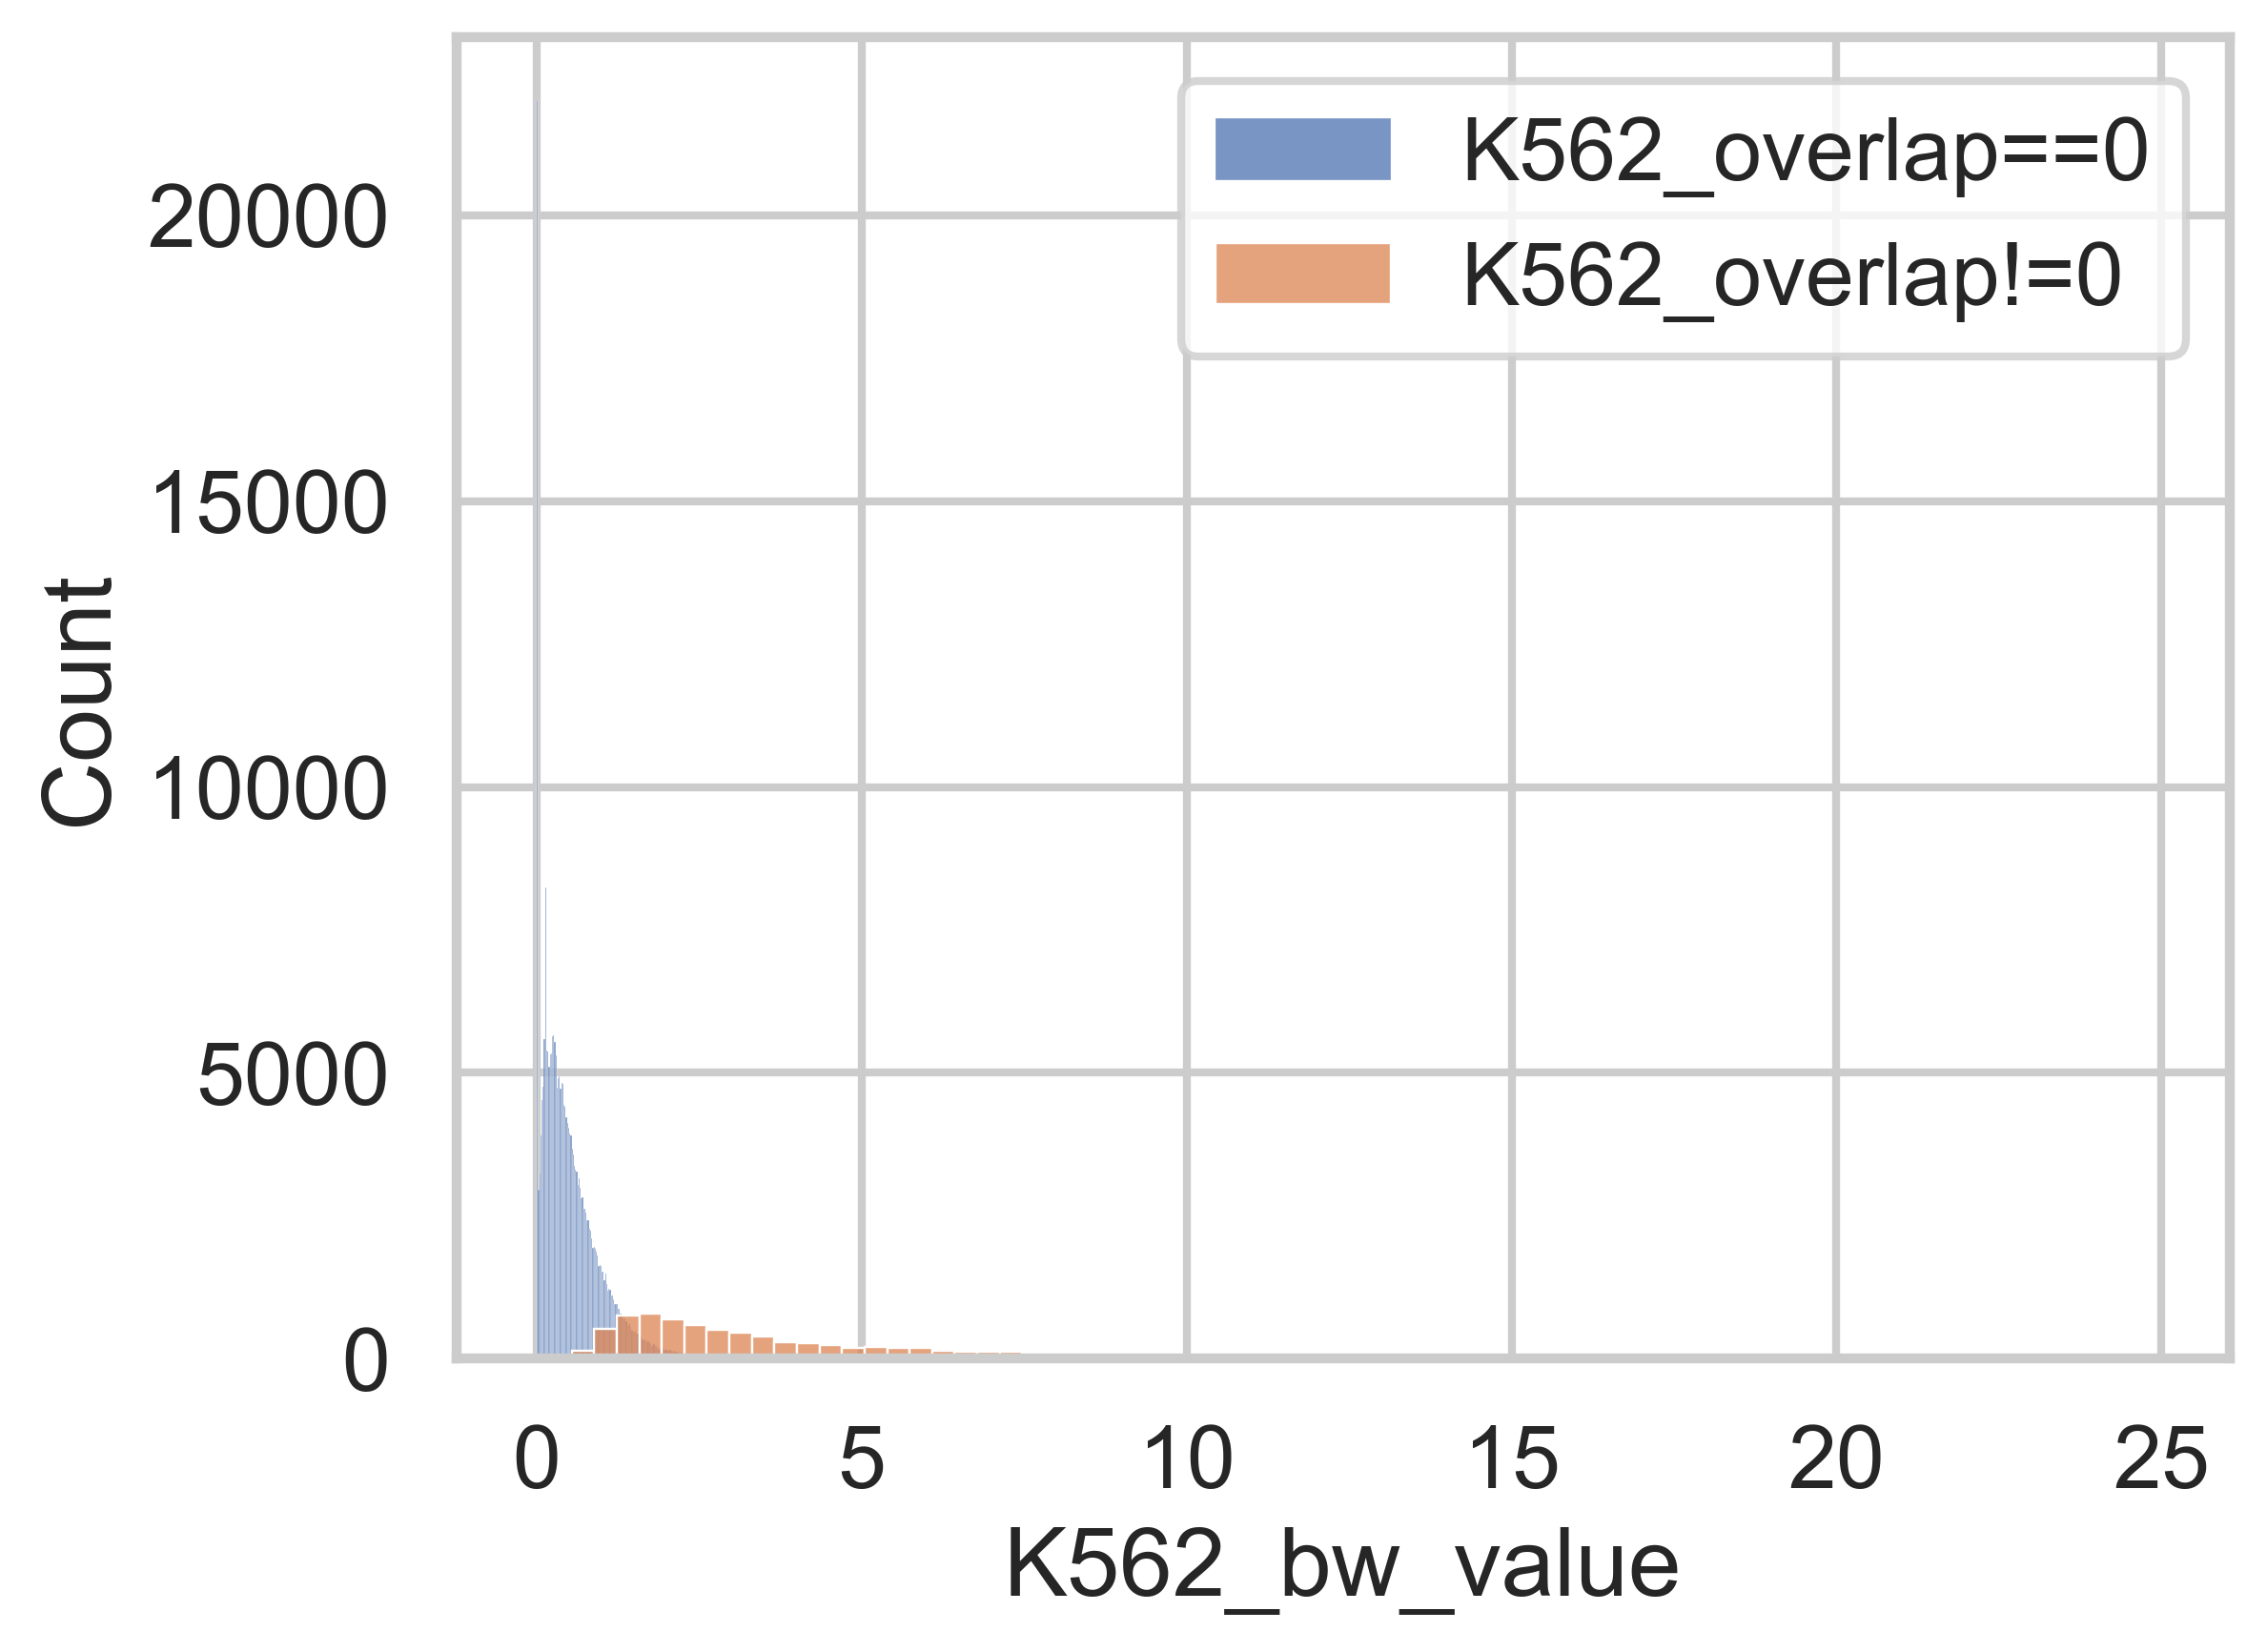

In [13]:
df0 = df[df['K562_overlap'] == 0]
g = sns.histplot(x=df0['K562_bw_value'], label='K562_overlap==0')
df0 = df[df['K562_overlap'] != 0]
g = sns.histplot(x=df0['K562_bw_value'], label='K562_overlap!=0')
plt.legend()

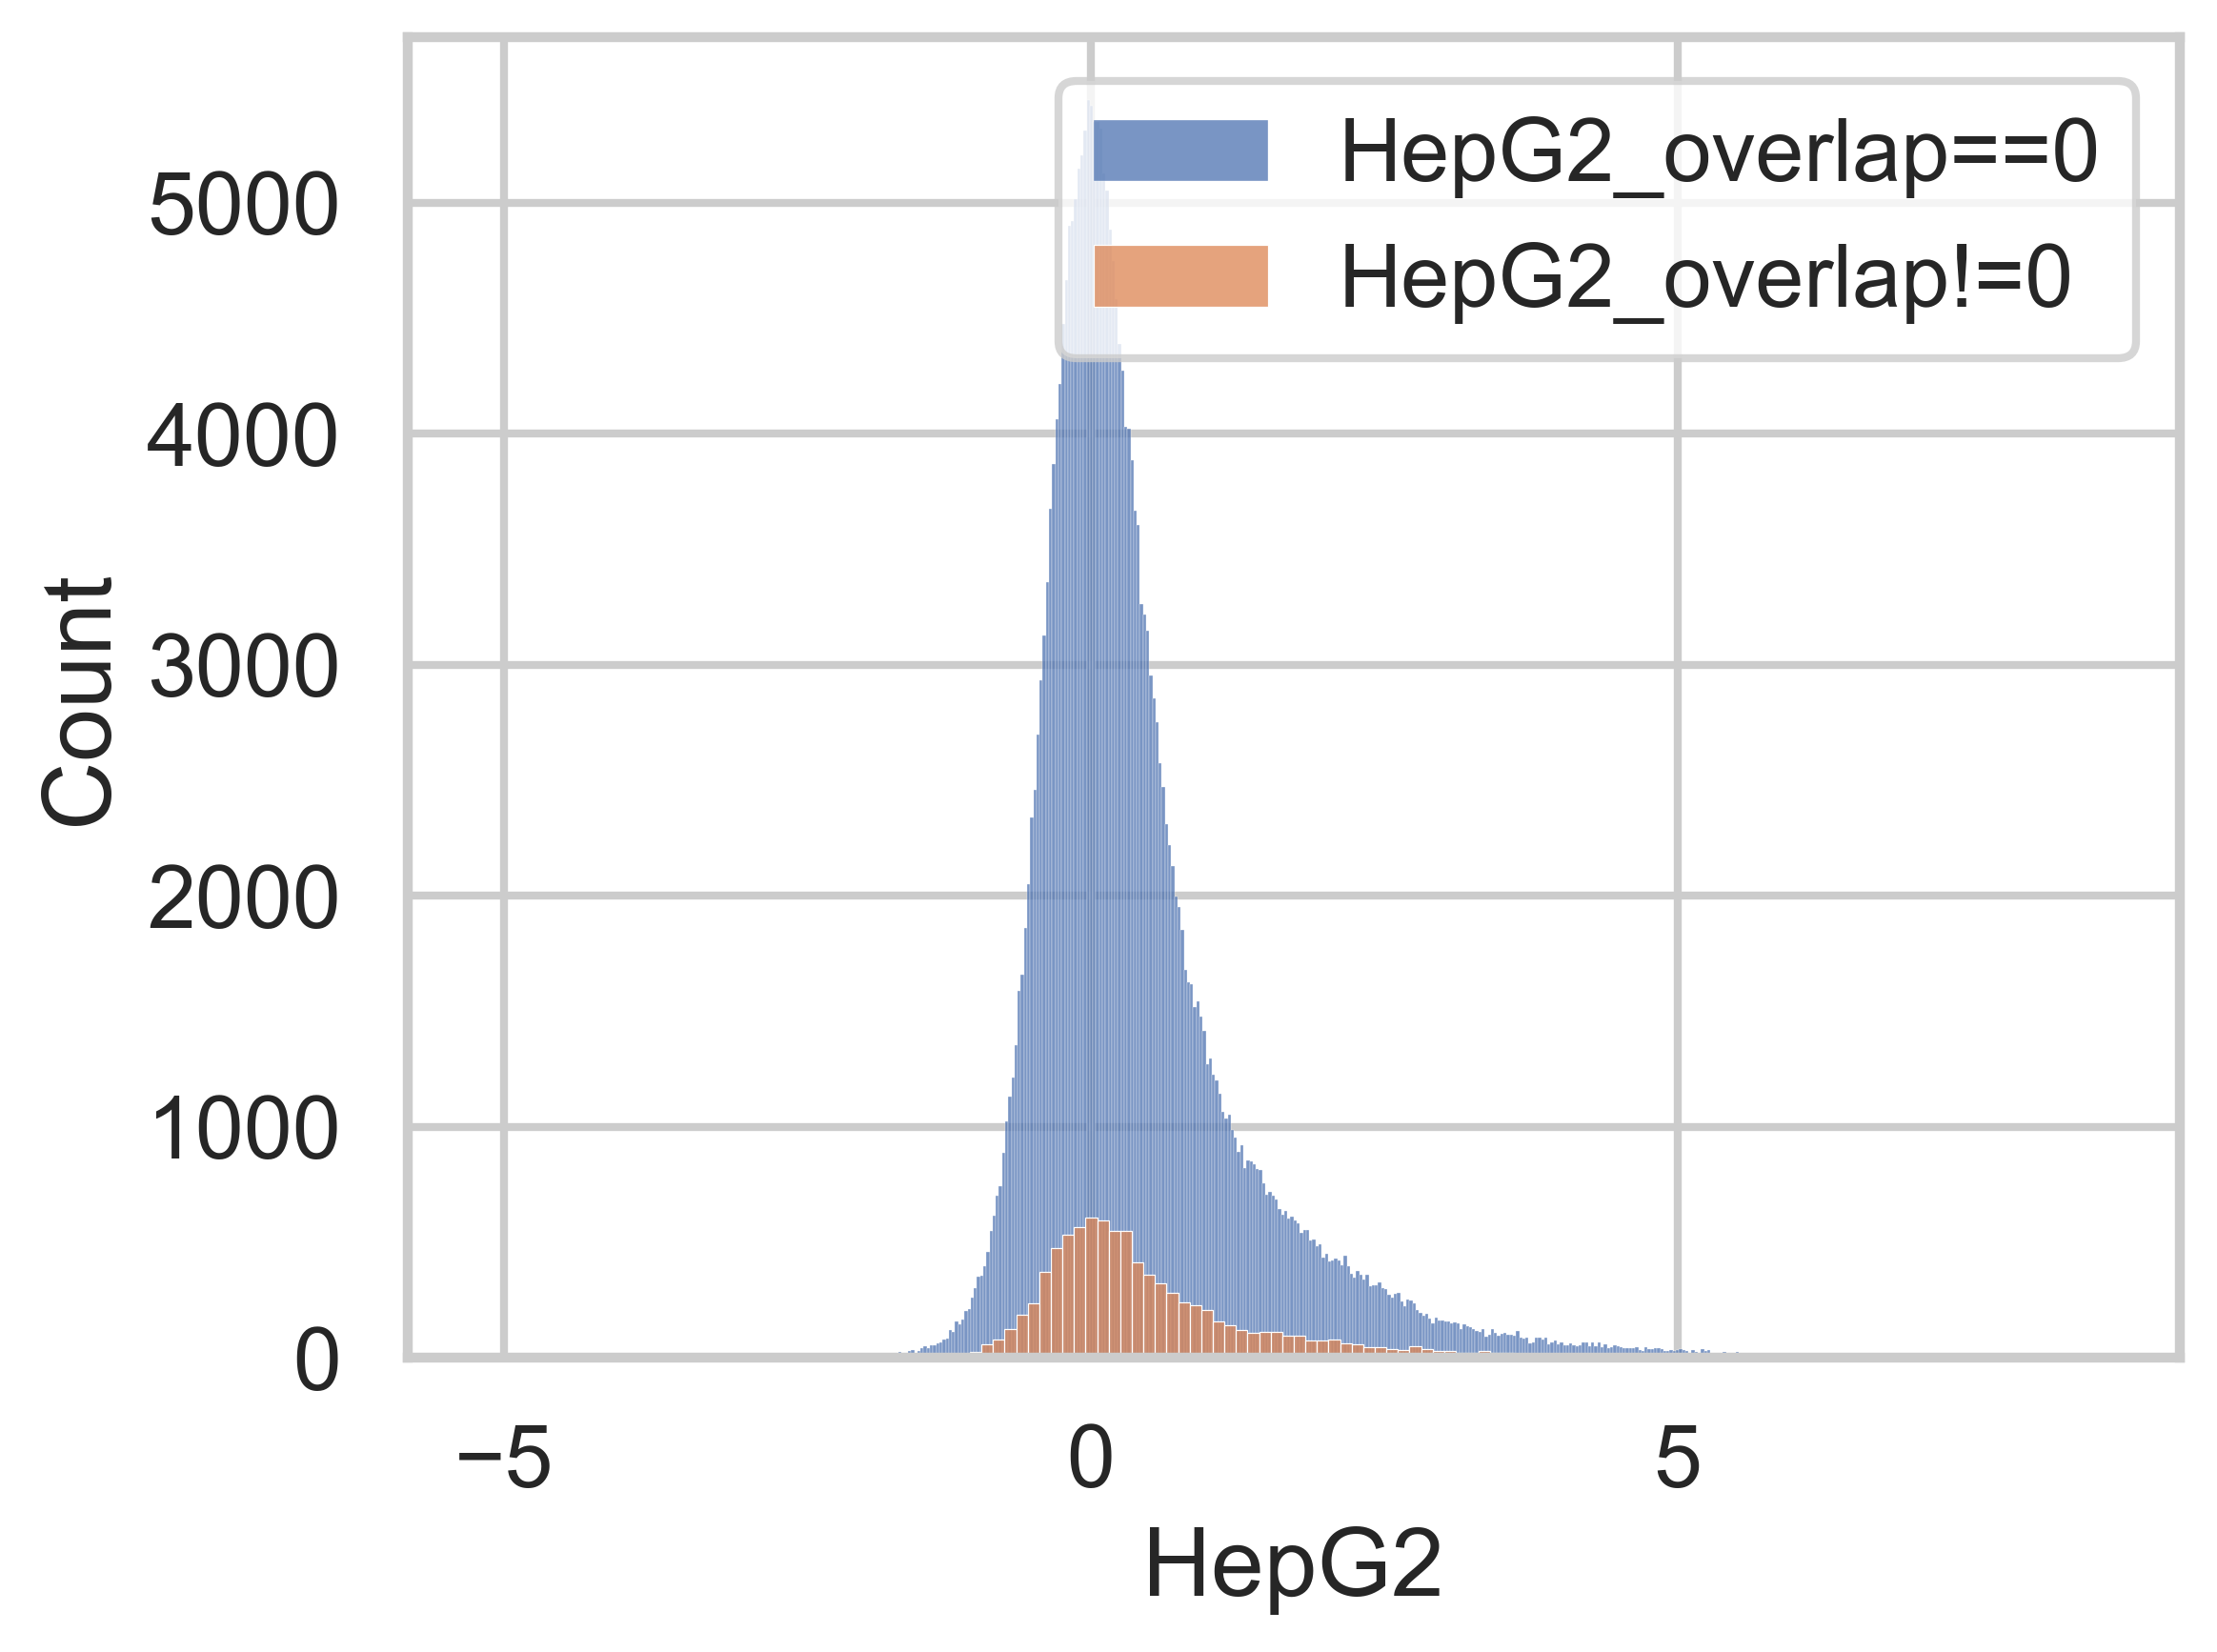

In [10]:
df0 = df[df['HepG2_overlap'] == 0]
g = sns.histplot(x=df0['HepG2'], label='HepG2_overlap==0')
df0 = df[df['HepG2_overlap'] != 0]
g = sns.histplot(x=df0['HepG2'], label='HepG2_overlap!=0')
plt.legend()

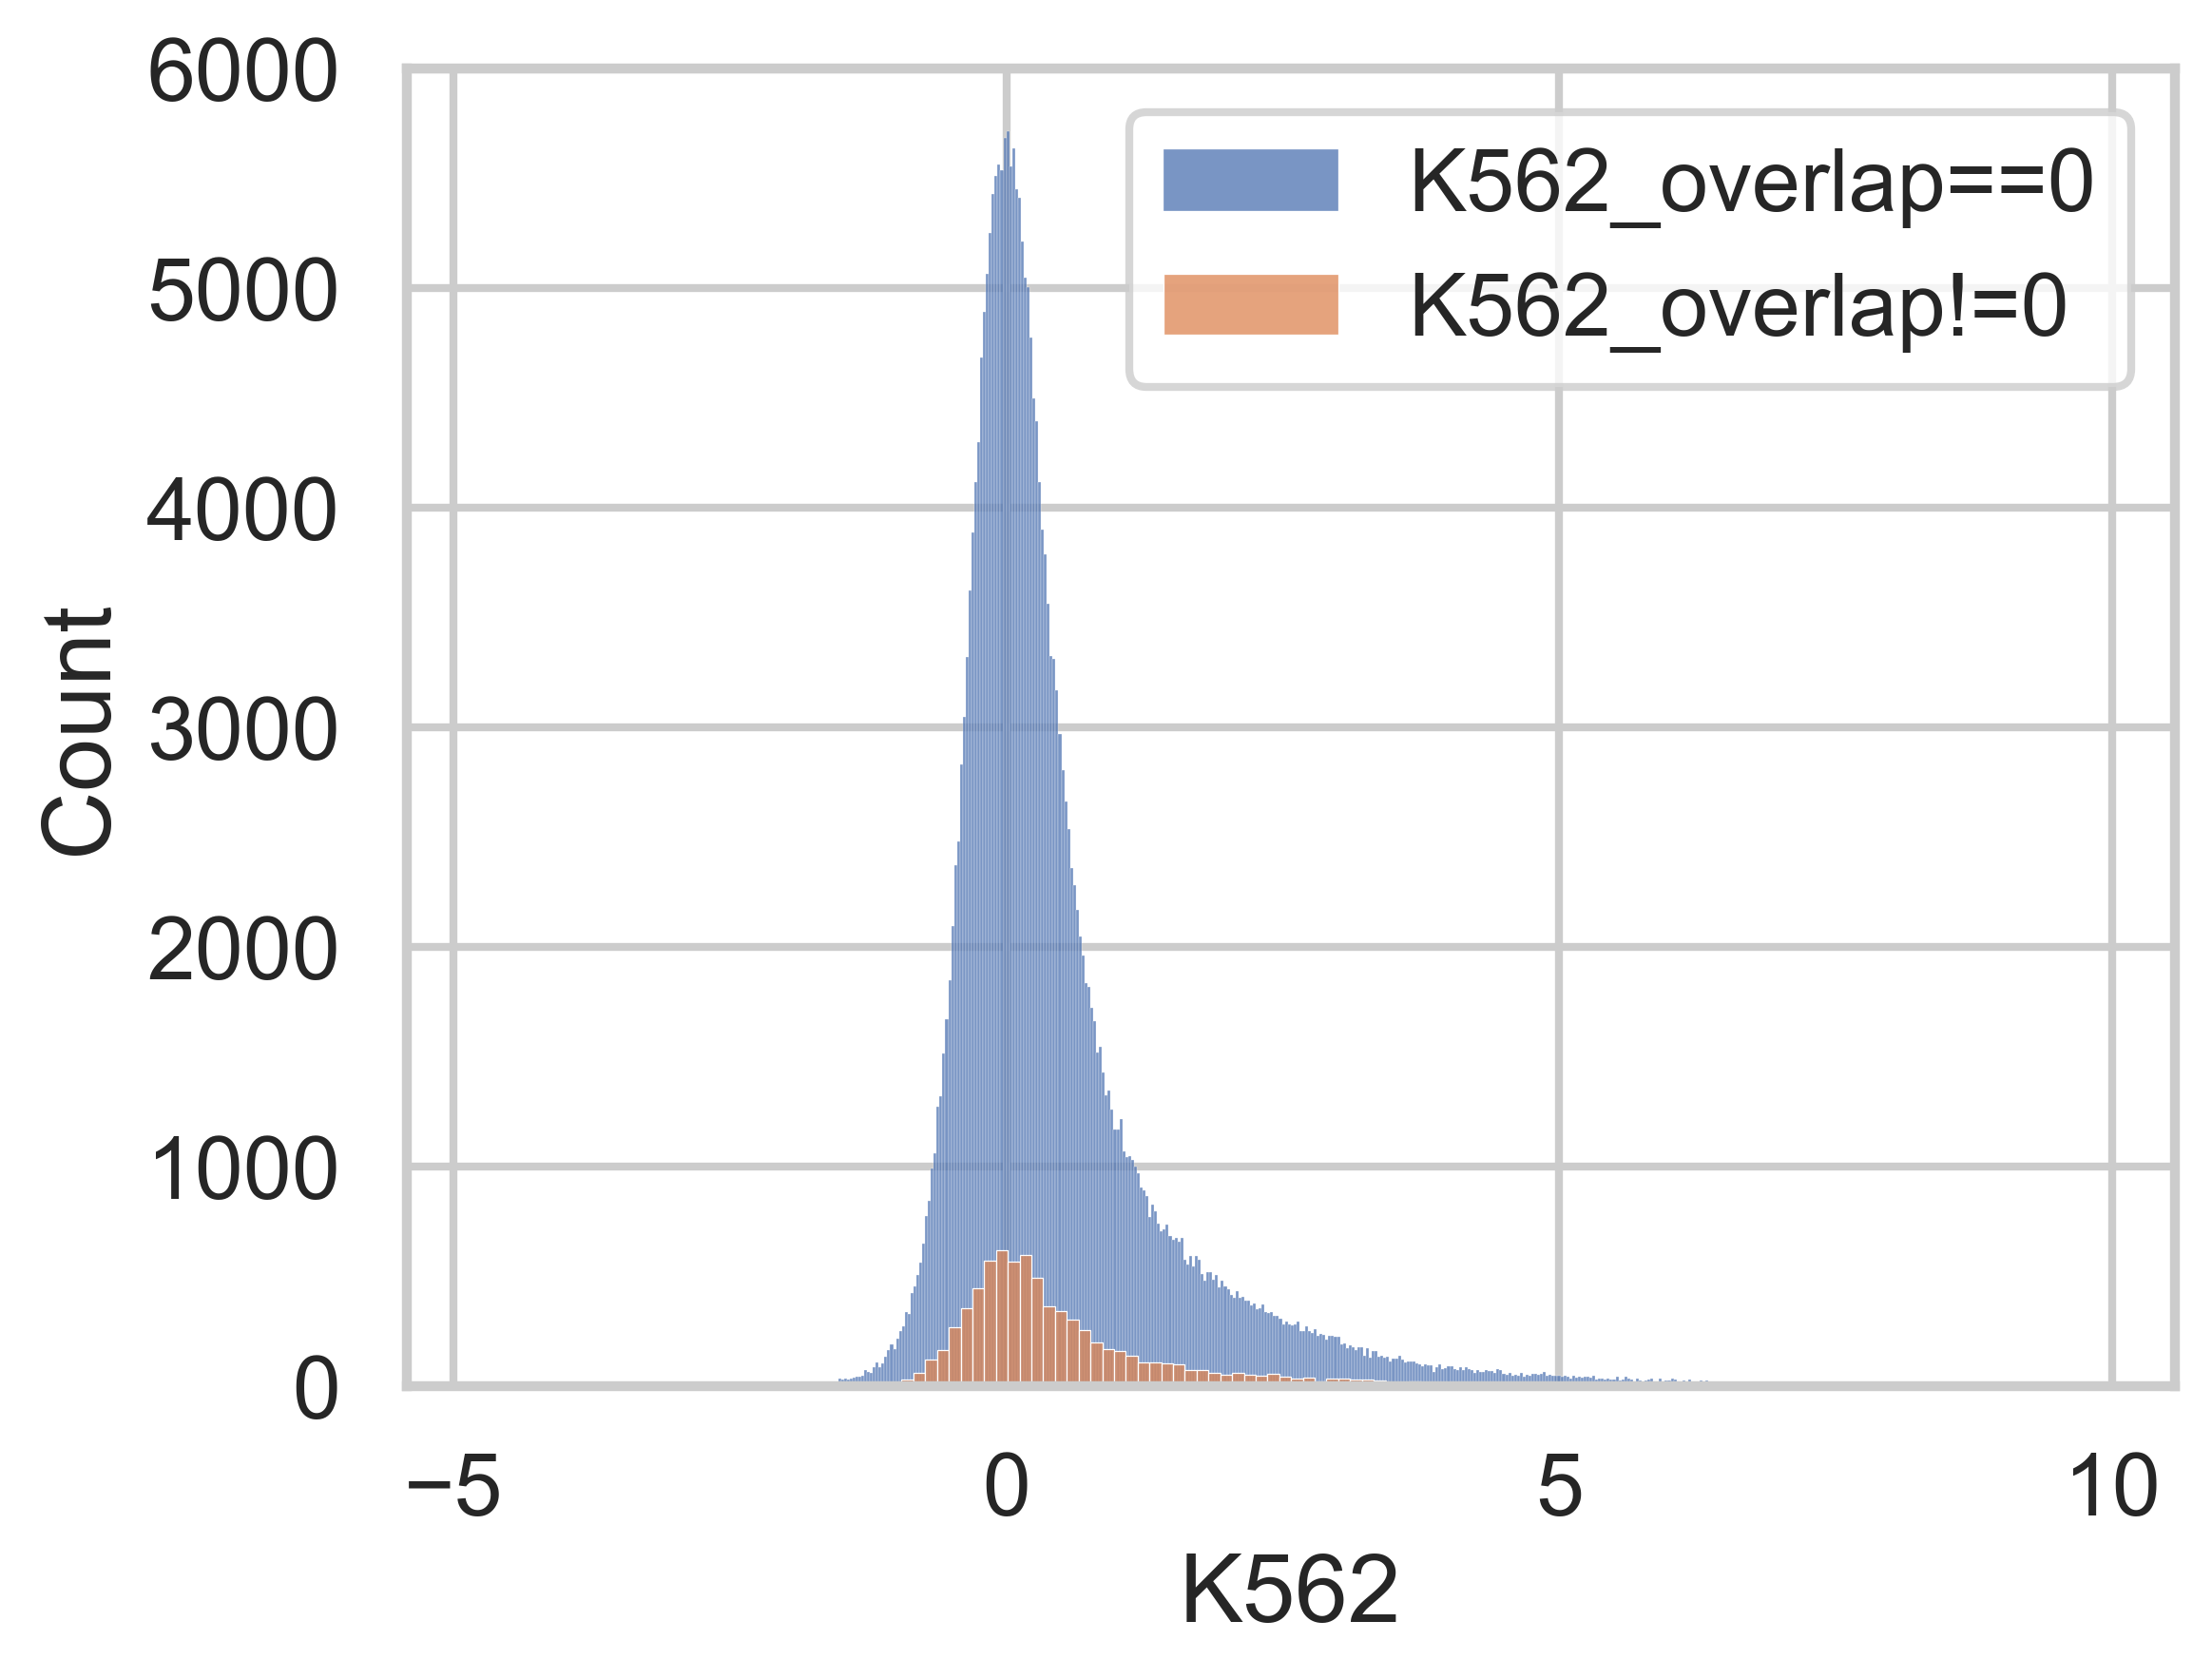

In [11]:
df0 = df[df['K562_overlap'] == 0]
g = sns.histplot(x=df0['K562'], label='K562_overlap==0')
df0 = df[df['K562_overlap'] != 0]
g = sns.histplot(x=df0['K562'], label='K562_overlap!=0')
plt.legend()

In [10]:
df = df.dropna().reset_index(drop=True)

In [11]:
df

chr      start        end     HepG2      K562     SKNSH  \
0       chr1      14577      14777  0.667516 -0.704147  0.538641   
1       chr1      63597      63797  1.269937 -0.391222  0.752052   
2       chr1      64664      64864 -0.211076 -0.007174  0.499376   
3       chr1     108130     108330 -0.332957 -0.149145 -1.048676   
4       chr1     108726     108926  0.607715  0.233677  0.511200   
...      ...        ...        ...       ...       ...       ...   
274922  chrX  155232003  155232203  0.579187  0.413490  0.651832   
274923  chrX  155232738  155232938 -0.351845  0.458449 -0.744355   
274924  chrX  155232998  155233198 -0.467091  0.338415 -0.797860   
274925  chrX  155233694  155233894  1.409758  0.556338  2.843295   
274926  chrX  155234630  155234830  0.312172  0.165634 -0.041383   

        HepG2_bw_value  K562_bw_value  
0             0.000000       0.000000  
1             0.000000       0.256219  
2             0.280116       0.533329  
3             0.000000       0.129465  
4             0.000000       0.130370  
...                ...            ...  
274922        0.036590       0.103210  
274923        0.324396       1.158998  
274924        0.605488       1.344624  
274925        0.645933       0.220926  
274926        0.423532       0.833065  

[274927 rows x 8 columns]

In [9]:
df.to_csv('SirajMPRA_bwvalues.csv', sep='\t', index=False)

In [10]:
df = pd.read_csv('SirajMPRA_bwvalues.csv', sep='\t')

In [11]:
df

chr      start        end     HepG2      K562     SKNSH  \
0       chr1      14577      14777  0.667516 -0.704147  0.538641   
1       chr1      63597      63797  1.269937 -0.391222  0.752052   
2       chr1      64664      64864 -0.211076 -0.007174  0.499376   
3       chr1     108130     108330 -0.332957 -0.149145 -1.048676   
4       chr1     108726     108926  0.607715  0.233677  0.511200   
...      ...        ...        ...       ...       ...       ...   
274922  chrX  155232003  155232203  0.579187  0.413490  0.651832   
274923  chrX  155232738  155232938 -0.351845  0.458449 -0.744355   
274924  chrX  155232998  155233198 -0.467091  0.338415 -0.797860   
274925  chrX  155233694  155233894  1.409758  0.556338  2.843295   
274926  chrX  155234630  155234830  0.312172  0.165634 -0.041383   

        HepG2_bw_value  K562_bw_value  
0             0.000000       0.000000  
1             0.000000       0.256219  
2             0.280116       0.533329  
3             0.000000       0.129465  
4             0.000000       0.130370  
...                ...            ...  
274922        0.036590       0.103210  
274923        0.324396       1.158998  
274924        0.605488       1.344624  
274925        0.645933       0.220926  
274926        0.423532       0.833065  

[274927 rows x 8 columns]

In [16]:
df0 = df[df['HepG2_bw_value'] != 0]
df0['HepG2_bw_value_log2'] = np.log2(df0['HepG2_bw_value']+1e-6)

/tmp/ipykernel_26180/2534083095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['HepG2_bw_value_log2'] = np.log2(df0['HepG2_bw_value']+1e-6)


PearsonRResult(statistic=0.031163561025154246, pvalue=2.2016918741749093e-56)


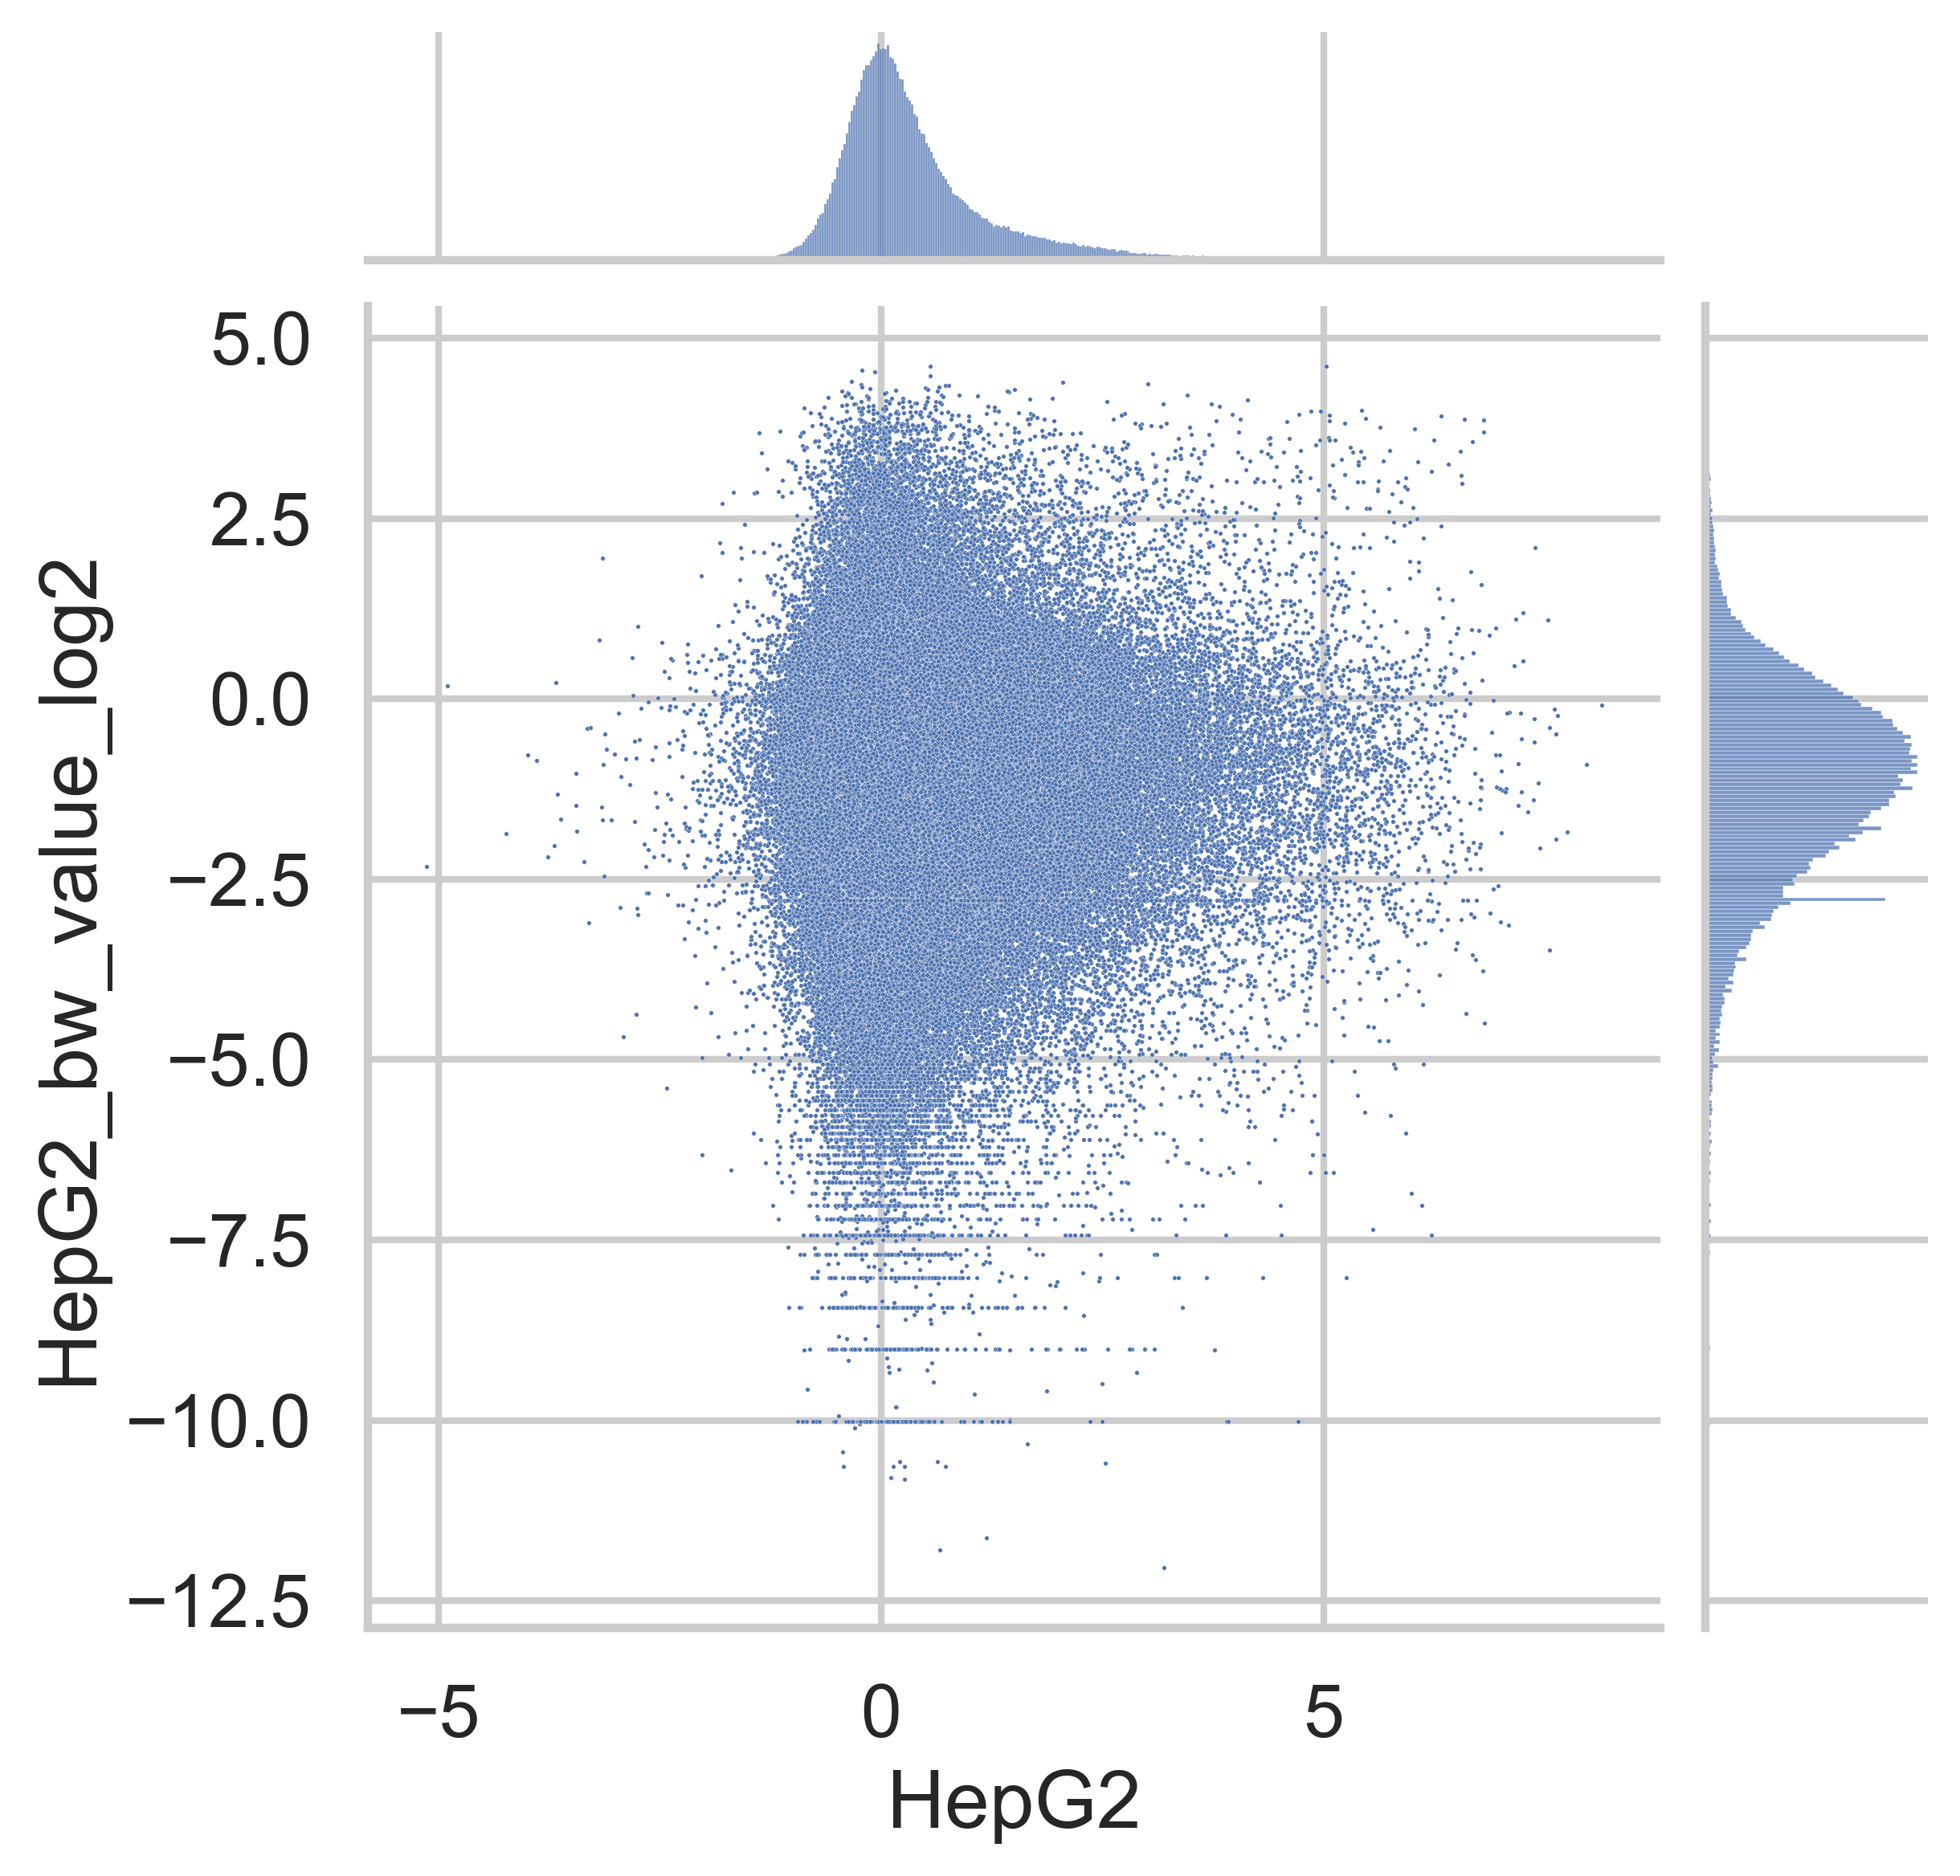

In [17]:
g = sns.jointplot(x=df0['HepG2'], y=df0['HepG2_bw_value_log2'], s=1)
print(pearsonr(x=df0['HepG2'], y=df0['HepG2_bw_value_log2']))

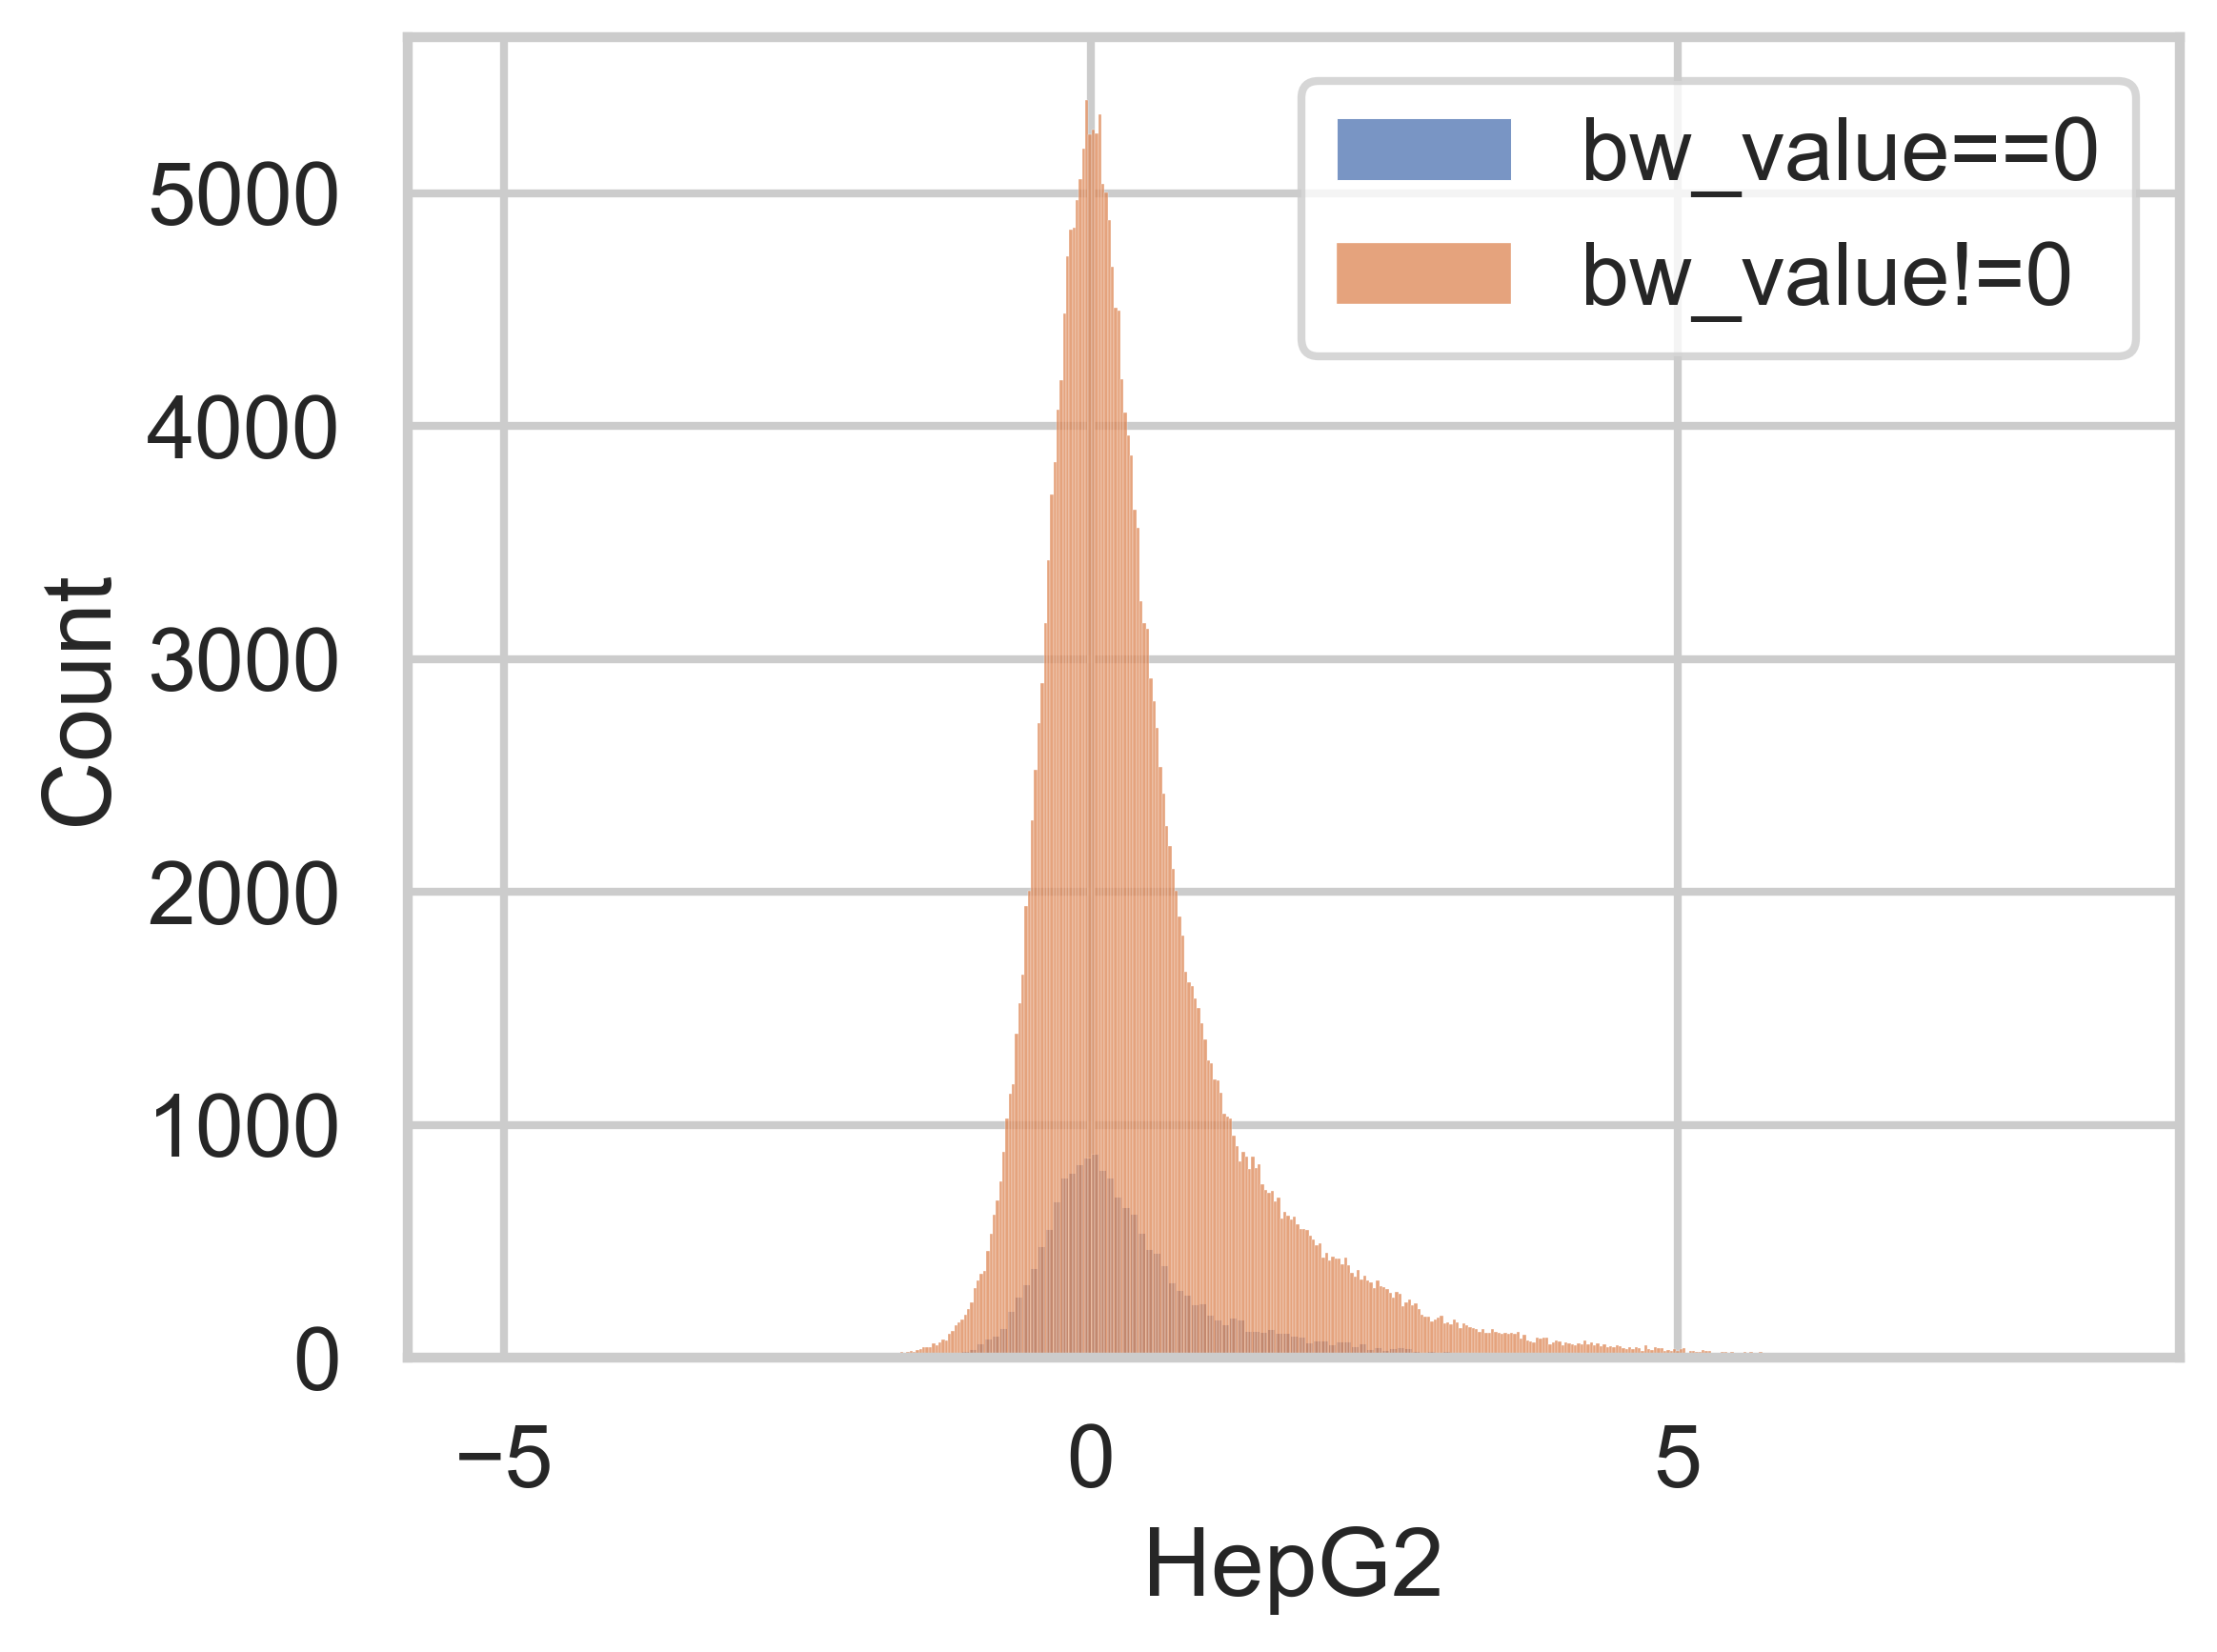

In [14]:
df0 = df[df['HepG2_bw_value'] == 0]
g = sns.histplot(x=df0['HepG2'], label='bw_value==0')
df0 = df[df['HepG2_bw_value'] != 0]
g = sns.histplot(x=df0['HepG2'], label='bw_value!=0')
plt.legend()

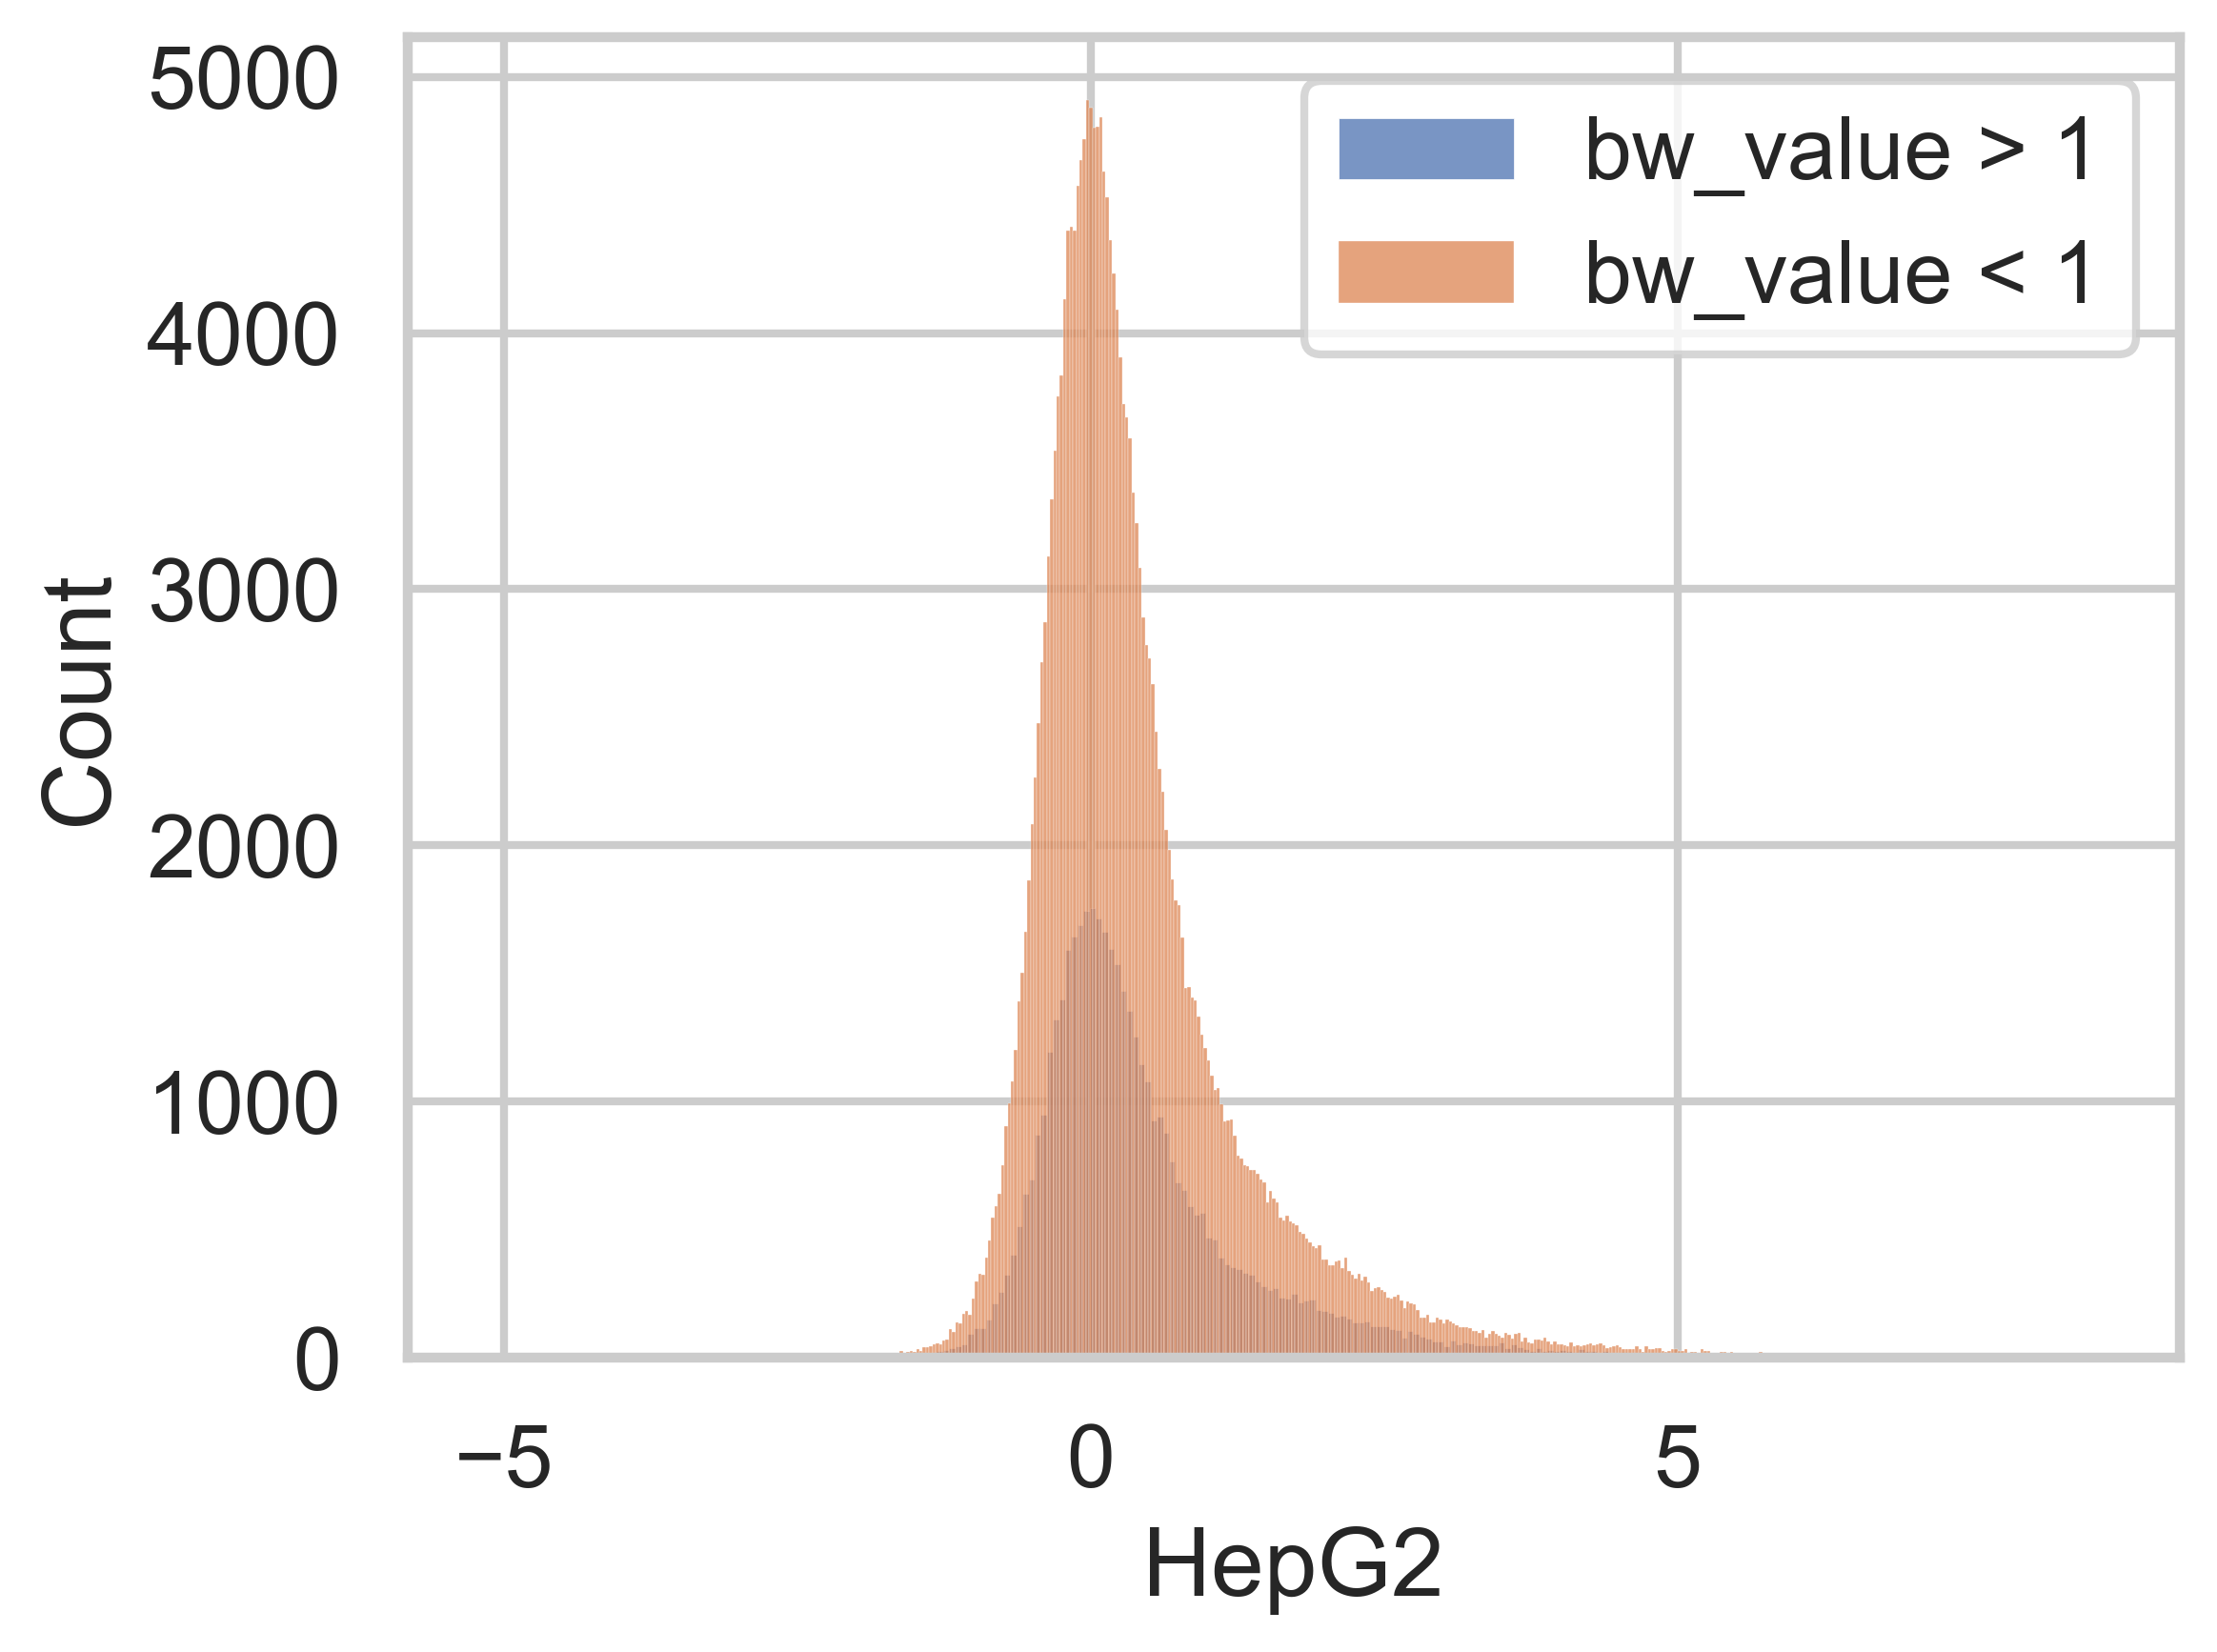

In [22]:
df0 = df[df['HepG2_bw_value'] > 1]
g = sns.histplot(x=df0['HepG2'], label='bw_value > 1')
df0 = df[df['HepG2_bw_value'] < 1]
g = sns.histplot(x=df0['HepG2'], label='bw_value < 1')
plt.legend()

PearsonRResult(statistic=0.016669848571254652, pvalue=2.3075030202510786e-18)


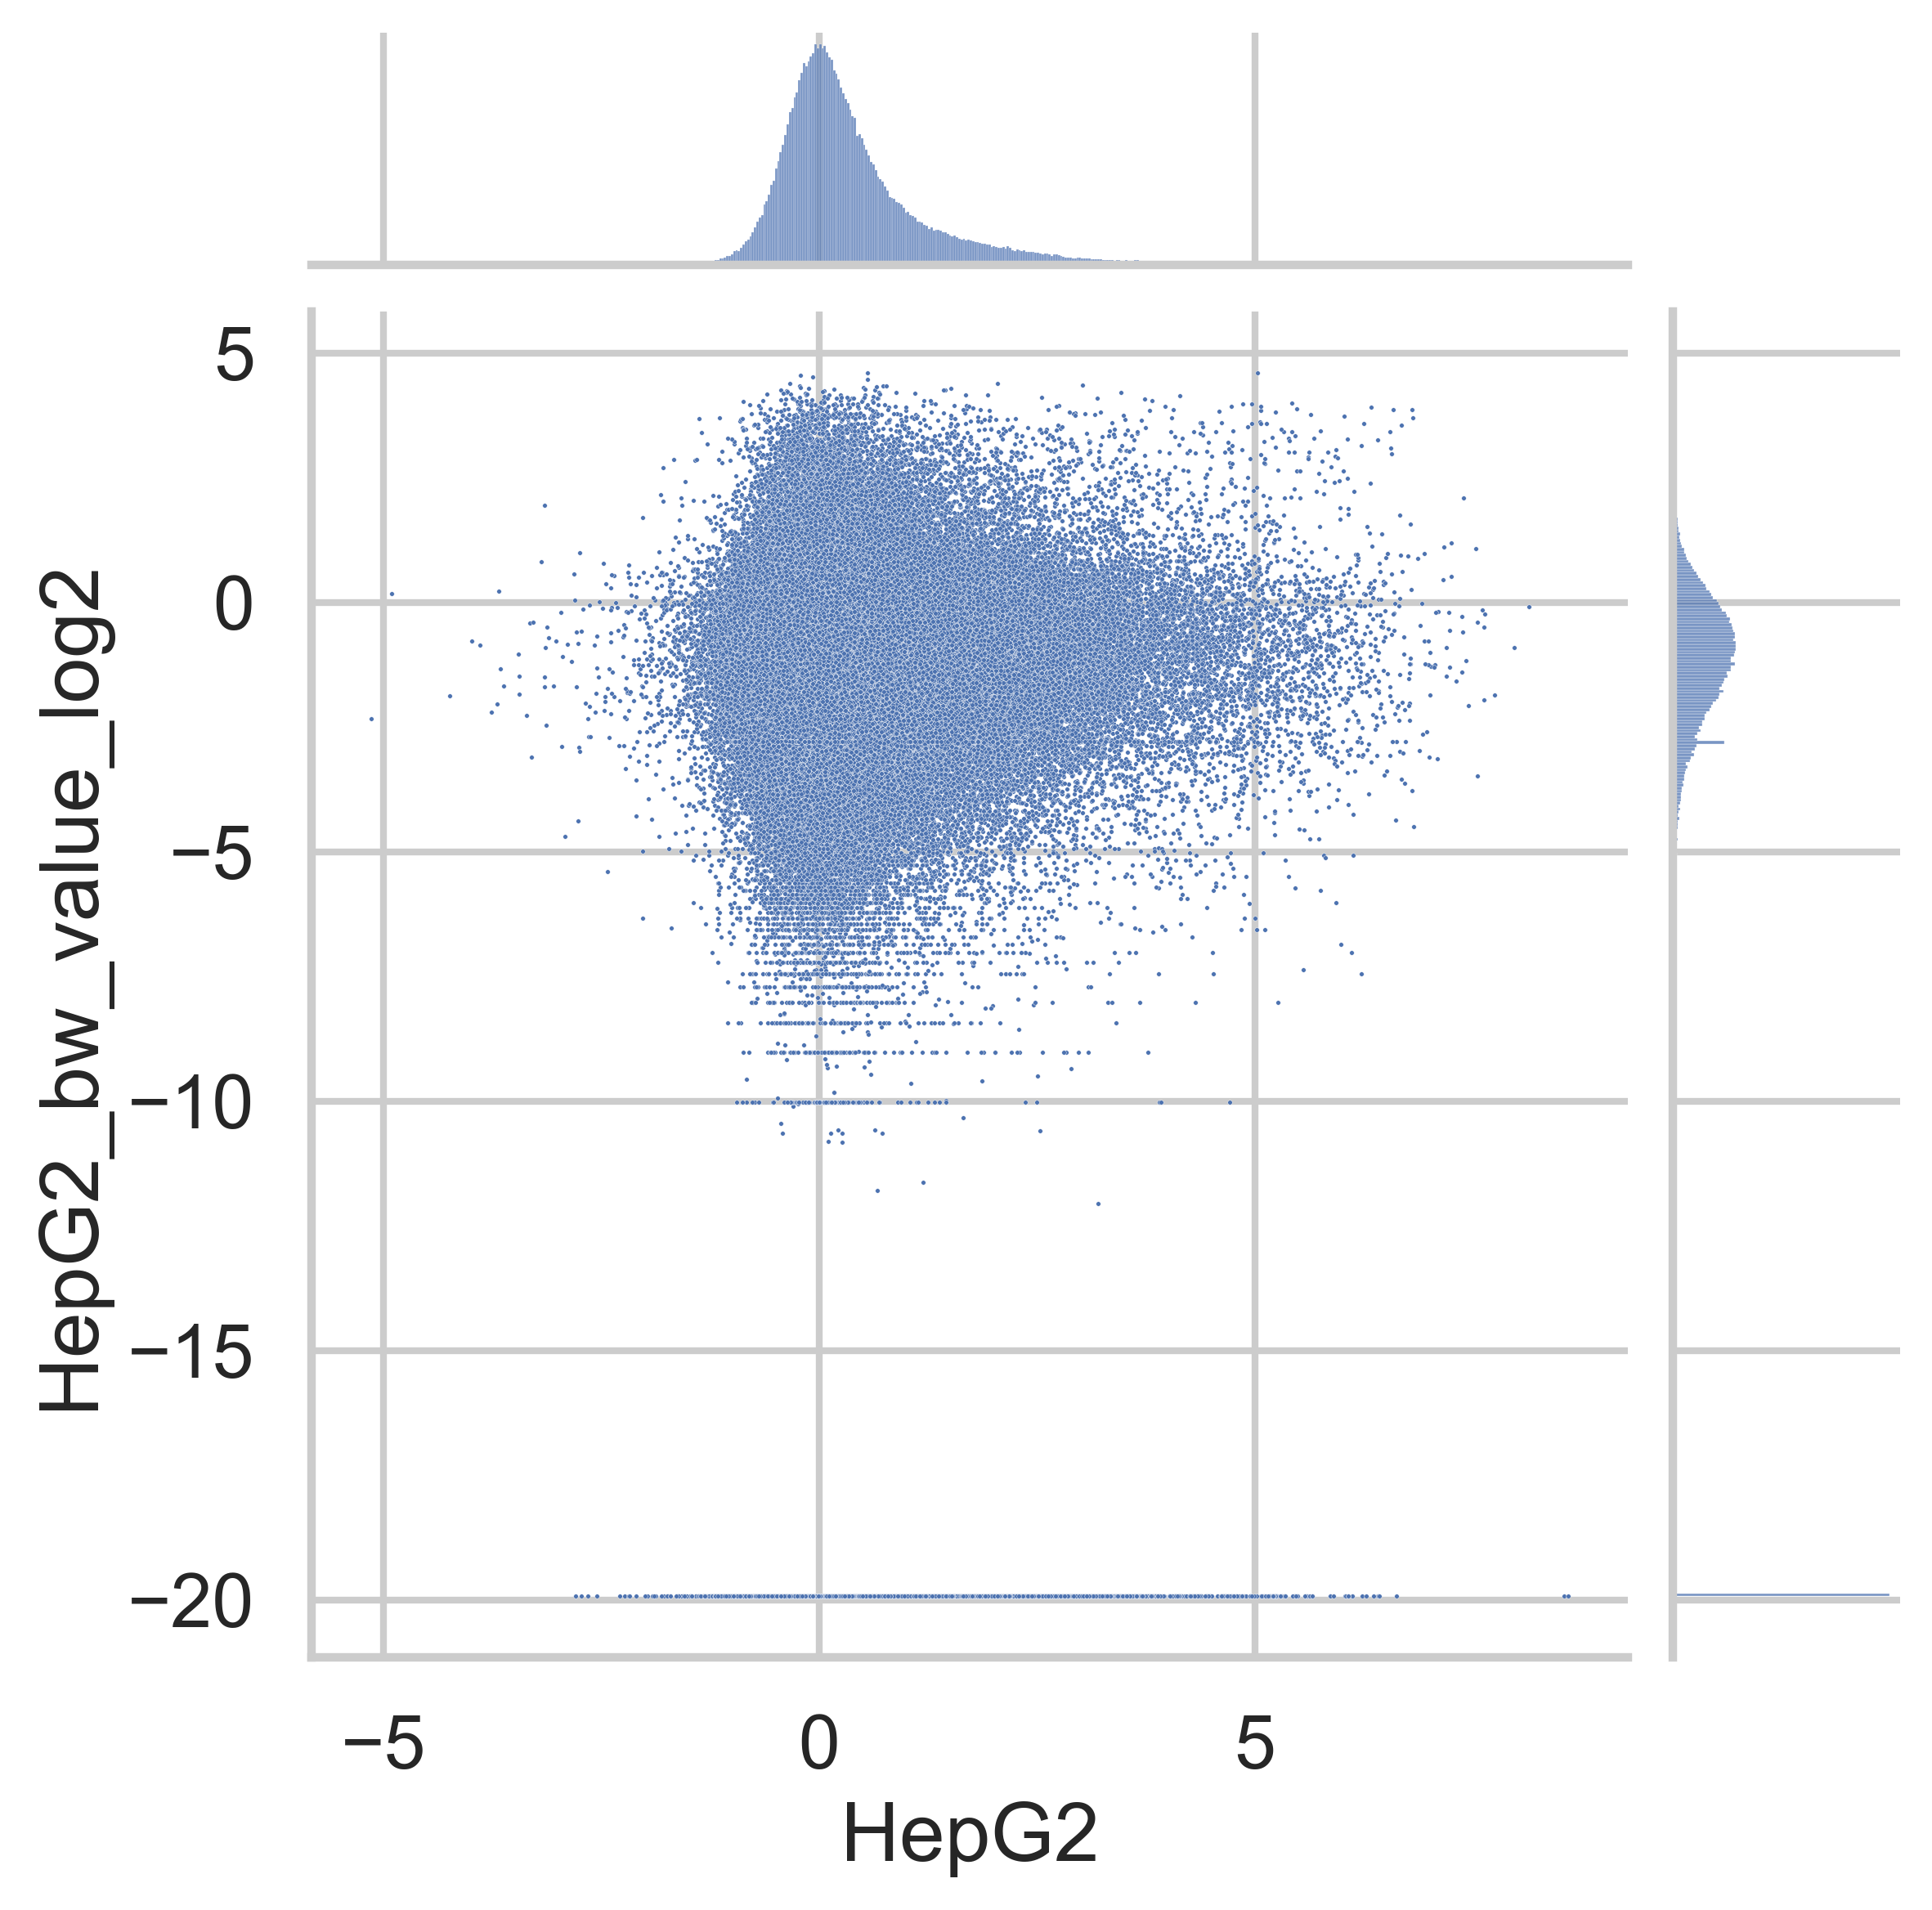

In [14]:
df['HepG2_bw_value_log2'] = np.log2(df['HepG2_bw_value']+1e-6)

g = sns.jointplot(x=df['HepG2'], y=df['HepG2_bw_value_log2'], s=1)
print(pearsonr(x=df['HepG2'], y=df['HepG2_bw_value_log2']))

PearsonRResult(statistic=0.043995368152268906, pvalue=7.461209172653583e-118)


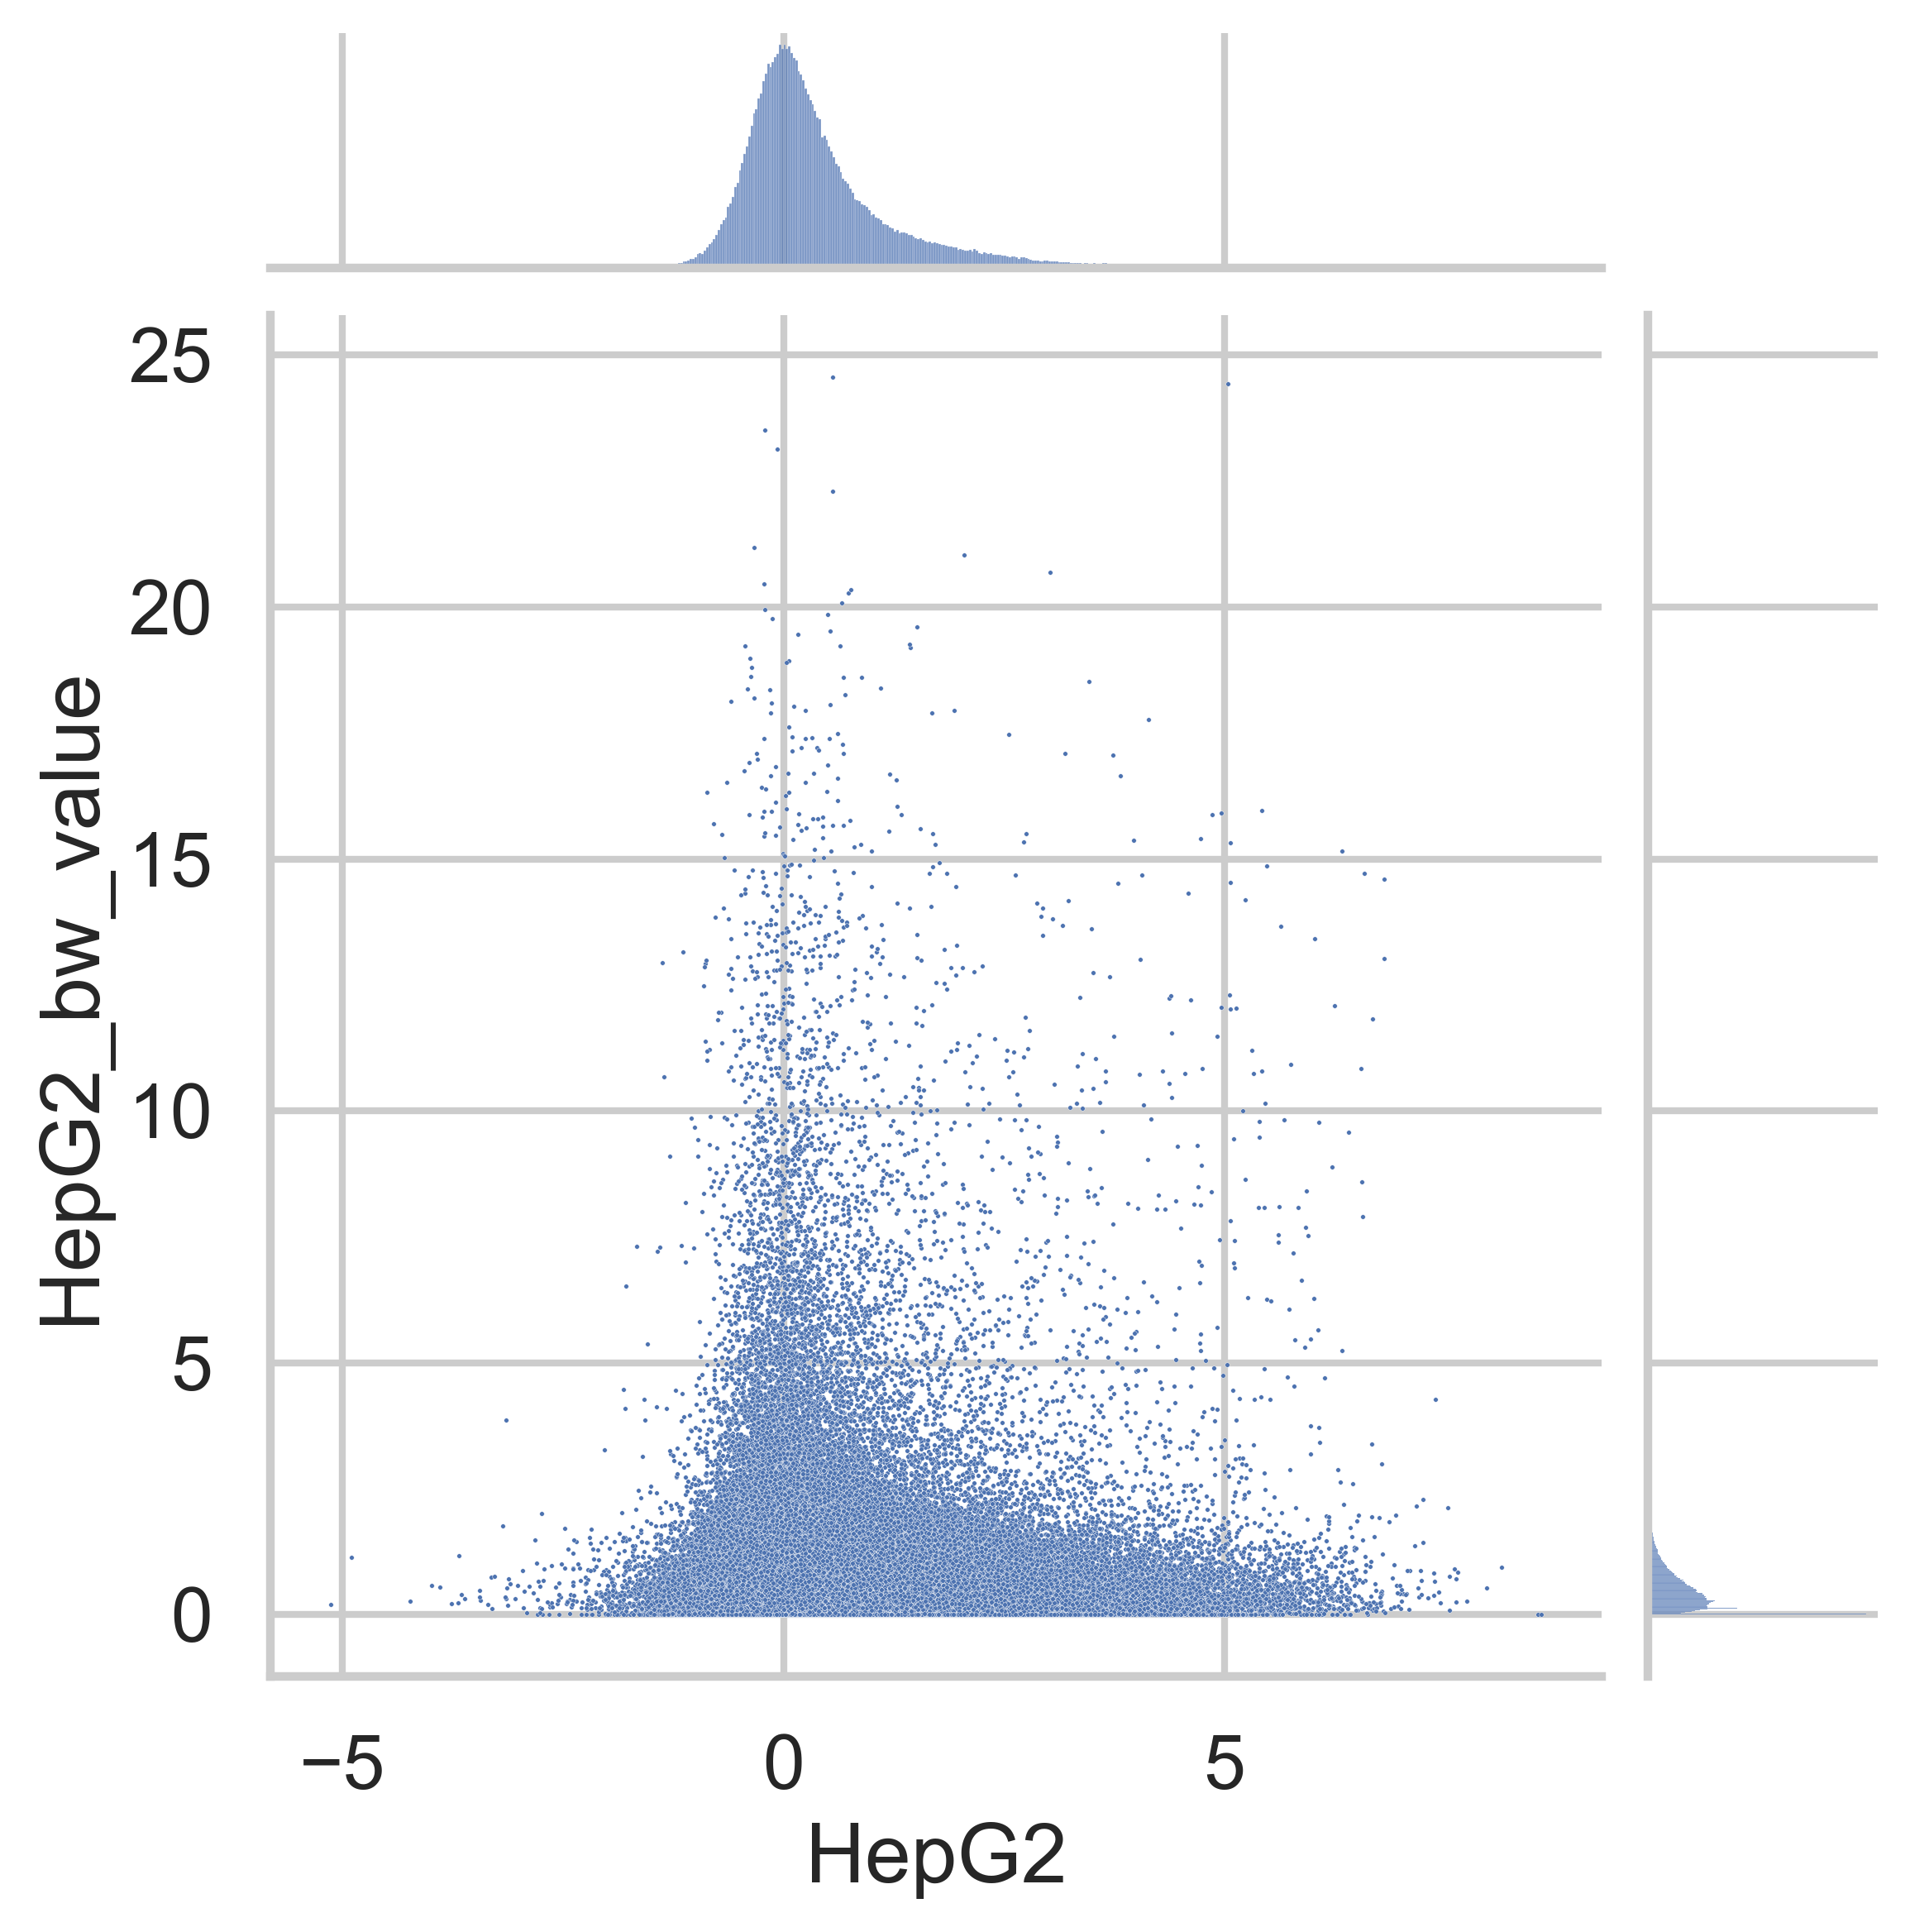

In [8]:
g = sns.jointplot(x=df['HepG2'], y=df['HepG2_bw_value'], s=1)
print(pearsonr(x=df['HepG2'], y=df['HepG2_bw_value']))

PearsonRResult(statistic=0.044358435393461716, pvalue=8.921852781527413e-120)


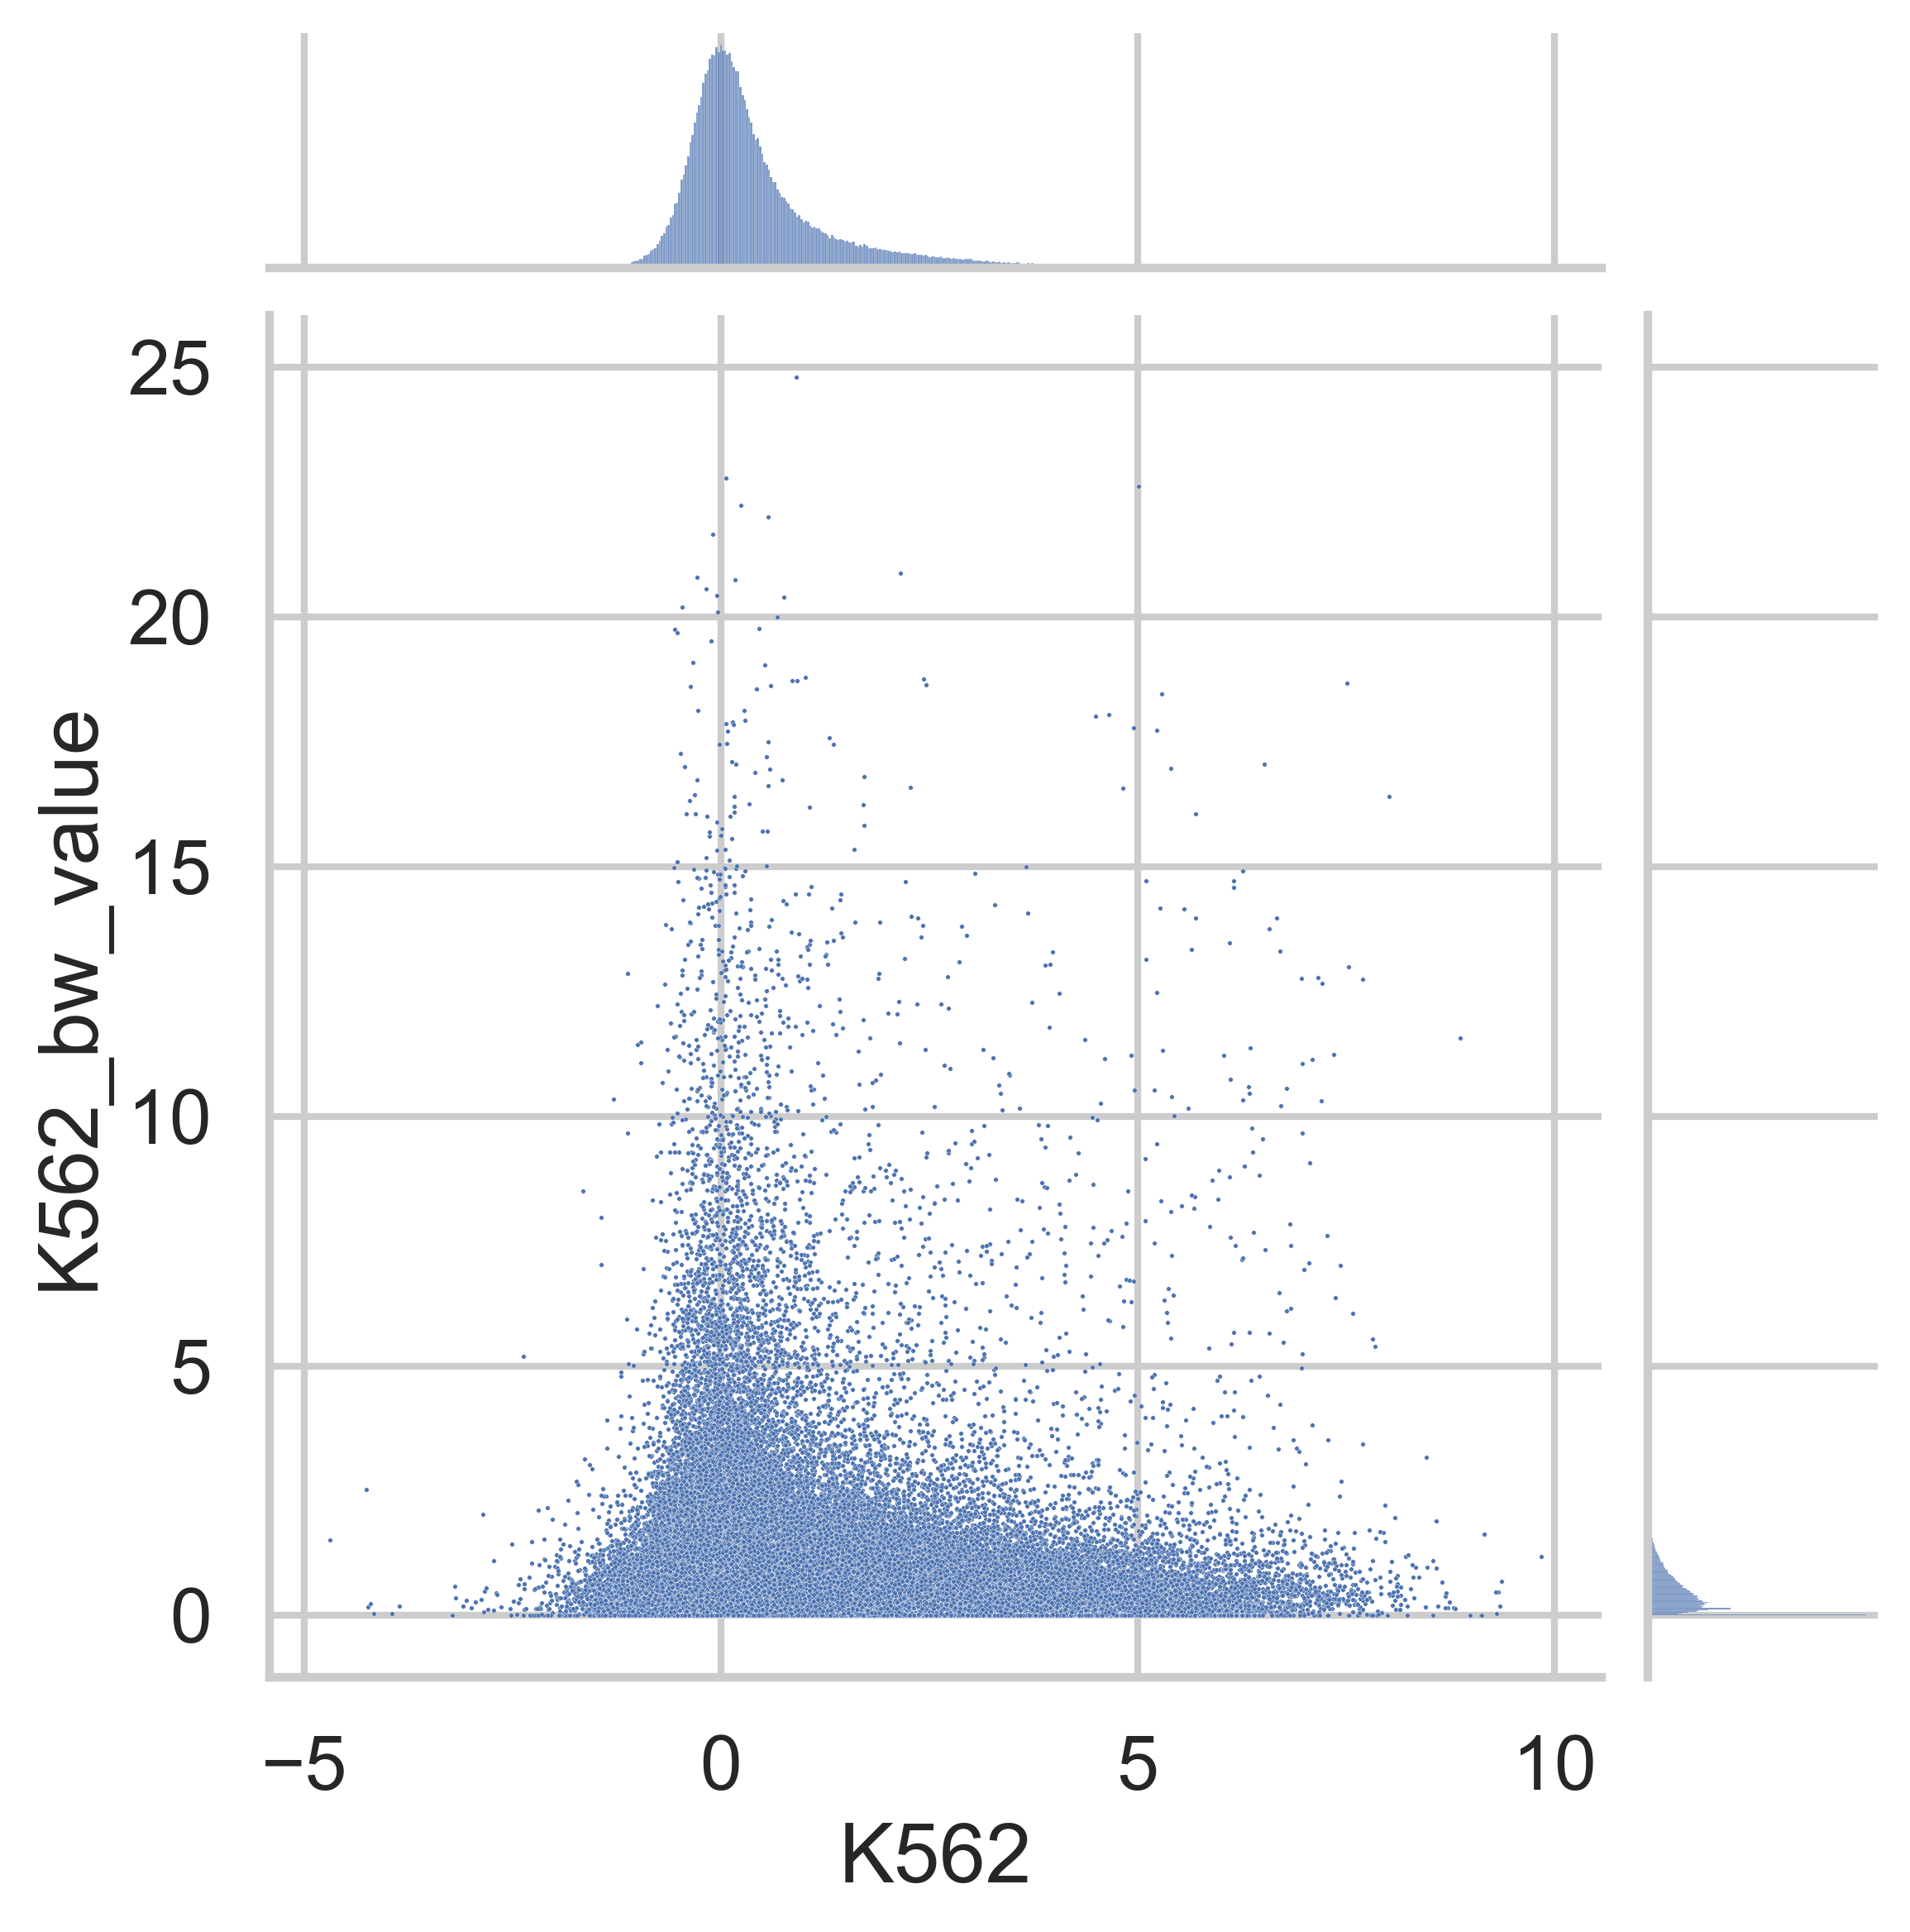

In [13]:
g = sns.jointplot(x=df['K562'], y=df['K562_bw_value'], s=1)
print(pearsonr(x=df['K562'], y=df['K562_bw_value']))